In [ ]:
import os

test_dataset = '/content/Acne-21/test'
val_dataset = '/content/Acne-21/valid'
train_dataset = '/content/Acne-21/train'

!pip install roboflow
from dotenv import load_dotenv
from roboflow import Roboflow
load_dotenv()
rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))
project = rf.workspace("kritsakorn").project("acne-kbm0q")
version = project.version(21)
dataset = version.download("voc")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Acne-21 in voc:: 100%|██████████| 2515/2515 [00:00<00:00, 9131.86it/s]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Dinov2Model, Dinov2Config
'''
class DinoSegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(DinoSegmentationModel, self).__init__()
        # Load the DinoV2 pre-trained model as the backbone
        self.backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

        # Replace the classification head with a segmentation head
        self.segmentation_head = nn.Sequential(
            # A convolutional layer that upscales the feature map to the input size
            nn.ConvTranspose2d(in_channels=8, out_channels=252, kernel_size=2, stride=2),

            # nn.BatchNorm2d(252),
            nn.ReLU(inplace=True),
            # Further layers can be added here as needed
            # The final layer should have 'num_classes' outputs for pixel-wise classification
            nn.Conv2d(in_channels=252, out_channels=num_classes, kernel_size=1)
        )

    def forward(self, x):
        # Pass the input through the backbone to get the feature map
        features = self.backbone.get_intermediate_layers(x, n=1)[0]  # You'll need to adapt this call to your backbone
        if features.dim() == 3:
          features = features.unsqueeze(0)
        features = self.backbone.norm(features)  # You may need to adapt normalization for segmentation
        # Ensure features have a batch dimension as well
        features = F.interpolate(features, size=x.size()[:-2], mode='bilinear', align_corners=False)
        # Upsample and process the feature map through the segmentation head
        seg_map = self.segmentation_head(features)
        print(seg_map.shape)
        print(x.size())

        return seg_map
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

#For normalization in train
class MyLayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(MyLayerNorm, self).__init__()
        self.norm = nn.LayerNorm(normalized_shape, eps=1e-6)

    def forward(self, x):
        # x is expected to be 4D with shape [batch_size, channels, height, width]
        # B, C, H, W = x.shape
        # Flatten the spatial dimensions, apply LayerNorm, and then restore the original shape
        # x = x.permute(0, 2, 3, 1).contiguous().view(B, H * W, C)
        x = self.norm(x)
        # x = x.view(B, H, W, C).permute(0, 3, 1, 2).contiguous()
        return x


class DinoSegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(DinoSegmentationModel, self).__init__()
        self.backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        self.num_classes = num_classes

        # Assuming your backbone outputs a feature map of size [batch_size, 384, 14, 14] for an input of 224x224
        # Adjust the in_channels to match your backbone's output feature dimension
        self.segmentation_head = nn.Sequential(
            # Upscale to a predefined size before final classification
            nn.ConvTranspose2d(in_channels=384, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
        )
        self.custom_norm = MyLayerNorm(normalized_shape=(384, 16, 16))

        # Adapt to your specific input size
        # self.resize_to_input = nn.Upsample(size=(12, 32), mode='bilinear', align_corners=False)

    def forward(self, x):
      features = self.backbone.get_intermediate_layers(x, n=1,reshape=True)[0]
      # features = self.backbone.norm(features)
      print(features.shape)
      features = self.custom_norm(features)
      # print("Features shape:", features.shape)
      seg_map = self.segmentation_head(features)
      # print("Segmentation map shape:", seg_map.shape)
      features_upsampled = F.interpolate(seg_map, size=(224,224), mode='bilinear', align_corners=False) # Be careful, this might introduce artifacts/be lossy
      # print("Features upsampled shape:", features_upsampled.shape)

      return features_upsampled

# Adjust your dataset transformations
from torchvision import transforms

class_dict = {
    'background':0,
    'dark spot':1,
    'blackheads':2,
    'whiteheads':3,
    'nodules':4,
    'pustules':5,
    'papules':6,
}
model = DinoSegmentationModel(num_classes=len(class_dict))


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
xFormers is not available (SwiGLU)
xFormers is not available (Attention)
xFormers is not available (Block)
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 106MB/s]


In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import xml.etree.ElementTree as ET
import numpy as np
from tqdm import tqdm

class SegmentationDataset(Dataset):
    def __init__(self, root_dir, class_dict, image_transform=None, mask_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and XML files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        if (image_transform == None):
          image_transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
          ])

        if(mask_transform == None):
          mask_transform = transforms.Compose([
              transforms.Resize(256, interpolation=Image.NEAREST),
              transforms.CenterCrop(224),
          ])

        self.root_dir = root_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.class_dict = class_dict
        self.image_paths = [os.path.join(root_dir, x) for x in os.listdir(root_dir) if x.endswith('.jpg') and os.path.exists(os.path.join(root_dir, x.replace('.jpg', '.xml')))]
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        xml_path = img_path.replace('.jpg', '.xml')
        image = Image.open(img_path).convert('RGB')
        mask = self._load_mask_from_xml(xml_path, image.size)

        image = self.image_transform(image)
        # mask = self.transform(mask)
        # mask = TF.resize(mask, (224, 224), interpolation=Image.NEAREST)  # Resize the mask with nearest neighbor
        mask = self.mask_transform(mask)
        # mask = np.array(mask).squeeze()
        # unq = np.unique(mask)
        mask = np.array(mask, dtype=np.uint8)
        mask = torch.from_numpy(mask).long()  # Convert to LongTensor for cross-entropy





        return image, mask


    def _load_mask_from_xml(self, xml_path, img_shape):
      class_dict=self.class_dict
      tree = ET.parse(xml_path)
      root = tree.getroot()
      # print(xml_path)

      # Initialize a mask with zeros (background)
      mask = np.zeros((img_shape[1], img_shape[0]), dtype=np.uint8)  # Note the shape order

      # Iterate over each object in the XML
      for obj in root.findall('object'):
          class_name = obj.find('name').text
          class_id = class_dict[class_name]

          # Extract bounding box coordinates
          bndbox = obj.find('bndbox')
          xmin = int(bndbox.find('xmin').text)
          xmax = int(bndbox.find('xmax').text)
          ymin = int(bndbox.find('ymin').text)
          ymax = int(bndbox.find('ymax').text)

          # Assign class_id to pixels within the bounding box
          mask[ymin:ymax, xmin:xmax] = class_id
          mask = mask.astype(np.uint8)


      # Convert mask to a PIL image
      return Image.fromarray(mask)



# Instantiate the datasets
train_dataset = SegmentationDataset(root_dir='/content/Acne-21/train', class_dict=class_dict)
val_dataset = SegmentationDataset(root_dir='/content/Acne-21/valid', class_dict=class_dict)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

i = 0
for inputs, mask in tqdm(train_loader):
  # if i == 96:
  #   print(train_dataset.image_paths[i])
  #   print(np.unique(mask))
  # i+=1
  pass



dataloaders = {'train': train_loader, 'val': val_loader}


100%|██████████| 121/121 [00:04<00:00, 26.76it/s]


/content/Acne-21/train/01F3MMVSTFKTNY4EVWF3NRVA5M_jpeg.rf.7be4ba15921c8af306dfa0e441e7fd06.jpg


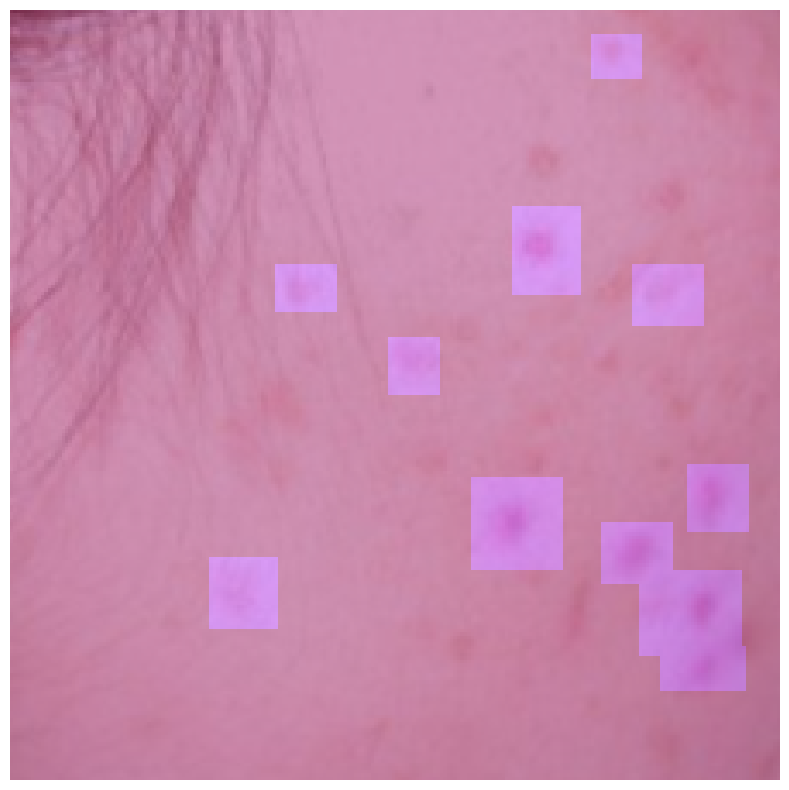

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# map every class to a random color
id2label = {
    0: 'background',
    1: 'dark spot',
    2: 'blackheads',
    3: 'whiteheads',
    4: 'nodules',
    5: 'pustules',
    6: 'papules',
}

np.random.seed(0)  # Ensure we always get the same colors
id2color = {k: list(np.random.choice(range(256), size=3)) for k, v in id2label.items()}

# Assuming 'train_dataset' is defined and has a method 'image_paths' and __getitem__
image_n = 96
image, mask = train_dataset[image_n]
print(train_dataset.image_paths[image_n])

def visualize_map(image, segmentation_map):
    # Assuming the segmentation map is a 4D tensor [batch_size, 1, height, width]
    segmentation_map = segmentation_map.squeeze()  # Remove the channel dimension
    if image.shape[0] == 3:  # assuming 3 channels
        image = image.permute(1, 2, 0)  # Convert from CHW to HWC
        image = (image * 255).type(torch.uint8).numpy()  # Convert to numpy array

    # Prepare the color overlay
    color_seg = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8)
    for label, color in id2color.items():
        color_seg[segmentation_map == label] = color

    # Combine the image with the color overlay
    alpha = 0.5  # Transparency for the overlay
    img = (1 - alpha) * image + alpha * color_seg
    img = img.astype(np.uint8)

    # Show image + mask
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
visualize_map(image, mask)

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import copy
from tqdm import tqdm


import matplotlib.pyplot as plt

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    val_iou_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            iou_scores = []  # List to store IoU scores for each batch

            for inputs, masks in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                masks = masks.to(device).long()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                preds = torch.argmax(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == masks.data)

                # Calculate IoU score
                intersection = torch.logical_and(masks.data, preds)
                union = torch.logical_or(masks.data, preds)
                iou_score = torch.sum(intersection) / torch.sum(union)
                iou_scores.append(iou_score.item())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / (len(dataloaders[phase].dataset) * masks.size(1) * masks.size(2))
            epoch_iou = sum(iou_scores) / len(iou_scores)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} IoU: {epoch_iou:.4f}')

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                scheduler.step()
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                val_iou_history.append(epoch_iou)

                if epoch_loss < best_loss and epoch_acc > best_acc:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Loss: {best_loss:.4f} Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot the training and validation loss
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(num_epochs), train_loss_history, label='Training Loss')
    plt.plot(range(num_epochs), val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot the validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(range(num_epochs), val_acc_history, label='Validation Accuracy (Pixelwise)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # Plot the validation IoU
    plt.subplot(1, 3, 3)
    plt.plot(range(num_epochs), val_iou_history, label='Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('Validation IoU')
    plt.legend()

    iou_disclaimer = "Note: IoU calculated per batch, not averaged over dataset."
    plt.text(0.5, -0.2, iou_disclaimer, ha='center', va='center', fontsize=8, color='red',
            transform=plt.subplot(1, 3, 3).transAxes)  # Position text relative to the IoU subplot


    plt.tight_layout()
    plt.show()

    return model




criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25)



Epoch 0/24
----------


  0%|          | 0/121 [00:00<?, ?it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 2/121 [00:00<00:40,  2.95it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 3/121 [00:00<00:35,  3.36it/s]

torch.Size([8, 384, 16, 16])


  3%|▎         | 4/121 [00:01<00:33,  3.53it/s]

torch.Size([8, 384, 16, 16])


  4%|▍         | 5/121 [00:01<00:36,  3.18it/s]

torch.Size([8, 384, 16, 16])


  5%|▍         | 6/121 [00:01<00:35,  3.26it/s]

torch.Size([8, 384, 16, 16])


  6%|▌         | 7/121 [00:02<00:37,  3.01it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 8/121 [00:02<00:33,  3.42it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


  8%|▊         | 10/121 [00:02<00:26,  4.26it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 10%|▉         | 12/121 [00:03<00:22,  4.75it/s]

torch.Size([8, 384, 16, 16])


 11%|█         | 13/121 [00:03<00:22,  4.84it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 12%|█▏        | 15/121 [00:03<00:23,  4.59it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 14%|█▍        | 17/121 [00:04<00:20,  4.98it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 16%|█▌        | 19/121 [00:04<00:21,  4.71it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 17%|█▋        | 21/121 [00:05<00:19,  5.08it/s]

torch.Size([8, 384, 16, 16])


 18%|█▊        | 22/121 [00:05<00:22,  4.35it/s]

torch.Size([8, 384, 16, 16])


 19%|█▉        | 23/121 [00:05<00:24,  4.03it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 21%|██        | 25/121 [00:06<00:22,  4.30it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 22%|██▏       | 27/121 [00:06<00:19,  4.76it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 24%|██▍       | 29/121 [00:06<00:18,  5.10it/s]

torch.Size([8, 384, 16, 16])


 25%|██▍       | 30/121 [00:07<00:18,  4.98it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 26%|██▋       | 32/121 [00:07<00:17,  5.17it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 28%|██▊       | 34/121 [00:07<00:17,  5.02it/s]

torch.Size([8, 384, 16, 16])


 29%|██▉       | 35/121 [00:08<00:18,  4.53it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 31%|███       | 37/121 [00:08<00:16,  5.06it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 32%|███▏      | 39/121 [00:08<00:16,  4.93it/s]

torch.Size([8, 384, 16, 16])


 33%|███▎      | 40/121 [00:09<00:16,  4.77it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 35%|███▍      | 42/121 [00:09<00:15,  5.14it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 36%|███▋      | 44/121 [00:09<00:15,  4.97it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 38%|███▊      | 46/121 [00:10<00:16,  4.44it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])

 39%|███▉      | 47/121 [00:10<00:16,  4.55it/s]


torch.Size([8, 384, 16, 16])


 40%|████      | 49/121 [00:10<00:14,  4.91it/s]

torch.Size([8, 384, 16, 16])


 41%|████▏     | 50/121 [00:11<00:15,  4.56it/s]

torch.Size([8, 384, 16, 16])


 42%|████▏     | 51/121 [00:11<00:15,  4.49it/s]

torch.Size([8, 384, 16, 16])


 43%|████▎     | 52/121 [00:11<00:16,  4.16it/s]

torch.Size([8, 384, 16, 16])


 44%|████▍     | 53/121 [00:11<00:16,  4.24it/s]

torch.Size([8, 384, 16, 16])


 45%|████▍     | 54/121 [00:12<00:15,  4.37it/s]

torch.Size([8, 384, 16, 16])


 45%|████▌     | 55/121 [00:12<00:16,  4.12it/s]

torch.Size([8, 384, 16, 16])


 46%|████▋     | 56/121 [00:12<00:16,  3.90it/s]

torch.Size([8, 384, 16, 16])


 47%|████▋     | 57/121 [00:13<00:19,  3.32it/s]

torch.Size([8, 384, 16, 16])


 48%|████▊     | 58/121 [00:13<00:21,  2.95it/s]

torch.Size([8, 384, 16, 16])


 49%|████▉     | 59/121 [00:13<00:21,  2.95it/s]

torch.Size([8, 384, 16, 16])


 50%|████▉     | 60/121 [00:14<00:21,  2.86it/s]

torch.Size([8, 384, 16, 16])


 50%|█████     | 61/121 [00:14<00:19,  3.10it/s]

torch.Size([8, 384, 16, 16])


 51%|█████     | 62/121 [00:14<00:18,  3.20it/s]

torch.Size([8, 384, 16, 16])


 52%|█████▏    | 63/121 [00:15<00:17,  3.35it/s]

torch.Size([8, 384, 16, 16])


 53%|█████▎    | 64/121 [00:15<00:18,  3.11it/s]

torch.Size([8, 384, 16, 16])


 54%|█████▎    | 65/121 [00:15<00:17,  3.12it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 55%|█████▌    | 67/121 [00:16<00:15,  3.45it/s]

torch.Size([8, 384, 16, 16])


 56%|█████▌    | 68/121 [00:16<00:15,  3.52it/s]

torch.Size([8, 384, 16, 16])


 57%|█████▋    | 69/121 [00:16<00:14,  3.69it/s]

torch.Size([8, 384, 16, 16])


 58%|█████▊    | 70/121 [00:17<00:14,  3.62it/s]

torch.Size([8, 384, 16, 16])


 59%|█████▊    | 71/121 [00:17<00:13,  3.77it/s]

torch.Size([8, 384, 16, 16])


 60%|█████▉    | 72/121 [00:17<00:13,  3.74it/s]

torch.Size([8, 384, 16, 16])


 60%|██████    | 73/121 [00:17<00:12,  3.96it/s]

torch.Size([8, 384, 16, 16])


 61%|██████    | 74/121 [00:17<00:11,  4.23it/s]

torch.Size([8, 384, 16, 16])


 62%|██████▏   | 75/121 [00:18<00:12,  3.77it/s]

torch.Size([8, 384, 16, 16])


 63%|██████▎   | 76/121 [00:18<00:13,  3.26it/s]

torch.Size([8, 384, 16, 16])


 64%|██████▎   | 77/121 [00:18<00:12,  3.39it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 65%|██████▌   | 79/121 [00:19<00:09,  4.30it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 67%|██████▋   | 81/121 [00:19<00:08,  4.93it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 69%|██████▊   | 83/121 [00:19<00:06,  5.50it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 70%|███████   | 85/121 [00:20<00:06,  5.74it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 72%|███████▏  | 87/121 [00:20<00:05,  5.72it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 74%|███████▎  | 89/121 [00:20<00:05,  5.86it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 75%|███████▌  | 91/121 [00:21<00:05,  5.90it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 77%|███████▋  | 93/121 [00:21<00:04,  5.87it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 79%|███████▊  | 95/121 [00:22<00:04,  5.87it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 80%|████████  | 97/121 [00:22<00:04,  5.89it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 82%|████████▏ | 99/121 [00:22<00:03,  5.86it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 83%|████████▎ | 101/121 [00:23<00:03,  5.83it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 85%|████████▌ | 103/121 [00:23<00:03,  5.89it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 87%|████████▋ | 105/121 [00:23<00:02,  5.88it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 107/121 [00:24<00:02,  5.90it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 90%|█████████ | 109/121 [00:24<00:02,  5.88it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 92%|█████████▏| 111/121 [00:24<00:01,  5.83it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 93%|█████████▎| 113/121 [00:25<00:01,  5.76it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 95%|█████████▌| 115/121 [00:25<00:01,  5.82it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 97%|█████████▋| 117/121 [00:25<00:00,  5.48it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 98%|█████████▊| 119/121 [00:26<00:00,  5.23it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


100%|██████████| 121/121 [00:26<00:00,  4.56it/s]


torch.Size([6, 384, 16, 16])
train Loss: 0.1549 Acc: 0.9698 IoU: 0.0000


  4%|▍         | 1/25 [00:00<00:02,  9.38it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 2/25 [00:00<00:02,  8.35it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 3/25 [00:00<00:02,  8.33it/s]

torch.Size([8, 384, 16, 16])


 16%|█▌        | 4/25 [00:00<00:02,  8.87it/s]

torch.Size([8, 384, 16, 16])


 20%|██        | 5/25 [00:00<00:02,  9.12it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 32%|███▏      | 8/25 [00:00<00:01,  9.46it/s]

torch.Size([8, 384, 16, 16])


 36%|███▌      | 9/25 [00:00<00:01,  9.30it/s]

torch.Size([8, 384, 16, 16])


 40%|████      | 10/25 [00:01<00:01,  9.14it/s]

torch.Size([8, 384, 16, 16])


 44%|████▍     | 11/25 [00:01<00:01,  9.12it/s]

torch.Size([8, 384, 16, 16])


 48%|████▊     | 12/25 [00:01<00:01,  9.18it/s]

torch.Size([8, 384, 16, 16])


 52%|█████▏    | 13/25 [00:01<00:01,  9.40it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▍   | 16/25 [00:01<00:00,  9.42it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 76%|███████▌  | 19/25 [00:02<00:00, 10.40it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 92%|█████████▏| 23/25 [00:02<00:00, 11.37it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


torch.Size([8, 384, 16, 16])
torch.Size([5, 384, 16, 16])
val Loss: 0.1139 Acc: 0.9789 IoU: 0.0000

Epoch 1/24
----------


  1%|          | 1/121 [00:00<00:21,  5.59it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


  2%|▏         | 3/121 [00:00<00:20,  5.88it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


  4%|▍         | 5/121 [00:00<00:19,  5.93it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


  6%|▌         | 7/121 [00:01<00:19,  5.88it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


  7%|▋         | 9/121 [00:01<00:19,  5.76it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


  9%|▉         | 11/121 [00:01<00:19,  5.67it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 11%|█         | 13/121 [00:02<00:18,  5.69it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 12%|█▏        | 15/121 [00:02<00:18,  5.70it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 14%|█▍        | 17/121 [00:02<00:18,  5.71it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 16%|█▌        | 19/121 [00:03<00:17,  5.81it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 17%|█▋        | 21/121 [00:03<00:17,  5.67it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 19%|█▉        | 23/121 [00:04<00:17,  5.70it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 21%|██        | 25/121 [00:04<00:16,  5.69it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 22%|██▏       | 27/121 [00:04<00:16,  5.71it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 24%|██▍       | 29/121 [00:05<00:15,  5.82it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 26%|██▌       | 31/121 [00:05<00:15,  5.82it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 27%|██▋       | 33/121 [00:05<00:15,  5.79it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 29%|██▉       | 35/121 [00:06<00:15,  5.72it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 31%|███       | 37/121 [00:06<00:14,  5.72it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 32%|███▏      | 39/121 [00:06<00:14,  5.62it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 34%|███▍      | 41/121 [00:07<00:13,  5.73it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 36%|███▌      | 43/121 [00:07<00:13,  5.75it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 37%|███▋      | 45/121 [00:07<00:13,  5.74it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 39%|███▉      | 47/121 [00:08<00:13,  5.61it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 40%|████      | 49/121 [00:08<00:12,  5.69it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 42%|████▏     | 51/121 [00:08<00:12,  5.76it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 44%|████▍     | 53/121 [00:09<00:12,  5.64it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 45%|████▍     | 54/121 [00:09<00:12,  5.48it/s]

torch.Size([8, 384, 16, 16])


 46%|████▋     | 56/121 [00:09<00:12,  5.24it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 48%|████▊     | 58/121 [00:10<00:12,  5.16it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 50%|████▉     | 60/121 [00:10<00:11,  5.10it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 51%|█████     | 62/121 [00:11<00:11,  4.99it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 53%|█████▎    | 64/121 [00:11<00:11,  5.04it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 55%|█████▍    | 66/121 [00:11<00:10,  5.12it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 56%|█████▌    | 68/121 [00:12<00:10,  5.06it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 58%|█████▊    | 70/121 [00:12<00:09,  5.34it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 60%|█████▉    | 72/121 [00:12<00:08,  5.53it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 61%|██████    | 74/121 [00:13<00:08,  5.57it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 63%|██████▎   | 76/121 [00:13<00:07,  5.67it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▍   | 78/121 [00:13<00:07,  5.74it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 66%|██████▌   | 80/121 [00:14<00:07,  5.65it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 68%|██████▊   | 82/121 [00:14<00:07,  5.56it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 69%|██████▉   | 84/121 [00:15<00:06,  5.63it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 71%|███████   | 86/121 [00:15<00:06,  5.68it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 73%|███████▎  | 88/121 [00:15<00:05,  5.65it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 74%|███████▍  | 90/121 [00:16<00:05,  5.67it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 76%|███████▌  | 92/121 [00:16<00:05,  5.71it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 78%|███████▊  | 94/121 [00:16<00:04,  5.55it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 79%|███████▉  | 96/121 [00:17<00:04,  5.71it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 81%|████████  | 98/121 [00:17<00:04,  5.67it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 83%|████████▎ | 100/121 [00:17<00:03,  5.51it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 84%|████████▍ | 102/121 [00:18<00:03,  5.61it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 86%|████████▌ | 104/121 [00:18<00:03,  5.49it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 106/121 [00:18<00:02,  5.52it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 89%|████████▉ | 108/121 [00:19<00:02,  5.59it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 91%|█████████ | 110/121 [00:19<00:01,  5.68it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 93%|█████████▎| 112/121 [00:19<00:01,  5.69it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 94%|█████████▍| 114/121 [00:20<00:01,  5.67it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 96%|█████████▌| 116/121 [00:20<00:00,  5.68it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 98%|█████████▊| 118/121 [00:21<00:00,  5.65it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 99%|█████████▉| 120/121 [00:21<00:00,  5.65it/s]

torch.Size([8, 384, 16, 16])
torch.Size([6, 384, 16, 16])


100%|██████████| 121/121 [00:21<00:00,  5.62it/s]


train Loss: 0.1538 Acc: 0.9698 IoU: 0.0000


  8%|▊         | 2/25 [00:00<00:01, 12.43it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 16%|█▌        | 4/25 [00:00<00:01, 12.27it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 24%|██▍       | 6/25 [00:00<00:01, 12.26it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 40%|████      | 10/25 [00:00<00:01, 10.81it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 48%|████▊     | 12/25 [00:01<00:01, 10.44it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 56%|█████▌    | 14/25 [00:01<00:01, 10.18it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 72%|███████▏  | 18/25 [00:01<00:00, 10.05it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 80%|████████  | 20/25 [00:01<00:00,  9.91it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 92%|█████████▏| 23/25 [00:02<00:00,  9.20it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


100%|██████████| 25/25 [00:02<00:00, 10.22it/s]


torch.Size([8, 384, 16, 16])
torch.Size([5, 384, 16, 16])
val Loss: 0.1202 Acc: 0.9789 IoU: 0.0000

Epoch 2/24
----------


  1%|          | 1/121 [00:00<00:25,  4.64it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 2/121 [00:00<00:24,  4.77it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])

  2%|▏         | 3/121 [00:00<00:24,  4.83it/s]

  3%|▎         | 4/121 [00:00<00:24,  4.68it/s]

torch.Size([8, 384, 16, 16])


  4%|▍         | 5/121 [00:01<00:24,  4.75it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


  6%|▌         | 7/121 [00:01<00:21,  5.25it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


  7%|▋         | 9/121 [00:01<00:20,  5.49it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


  9%|▉         | 11/121 [00:02<00:19,  5.56it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 11%|█         | 13/121 [00:02<00:19,  5.57it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 12%|█▏        | 15/121 [00:02<00:19,  5.54it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 14%|█▍        | 17/121 [00:03<00:18,  5.55it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 16%|█▌        | 19/121 [00:03<00:18,  5.51it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 17%|█▋        | 21/121 [00:03<00:18,  5.42it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 19%|█▉        | 23/121 [00:04<00:17,  5.56it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 21%|██        | 25/121 [00:04<00:17,  5.62it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 22%|██▏       | 27/121 [00:04<00:16,  5.61it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 24%|██▍       | 29/121 [00:05<00:16,  5.62it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 26%|██▌       | 31/121 [00:05<00:16,  5.62it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 27%|██▋       | 33/121 [00:06<00:15,  5.66it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 29%|██▉       | 35/121 [00:06<00:15,  5.66it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 31%|███       | 37/121 [00:06<00:14,  5.68it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 32%|███▏      | 39/121 [00:07<00:14,  5.69it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 34%|███▍      | 41/121 [00:07<00:13,  5.75it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 36%|███▌      | 43/121 [00:07<00:13,  5.77it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 37%|███▋      | 45/121 [00:08<00:12,  5.90it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 39%|███▉      | 47/121 [00:08<00:12,  5.90it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 40%|████      | 49/121 [00:08<00:12,  5.90it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 42%|████▏     | 51/121 [00:09<00:11,  5.96it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 44%|████▍     | 53/121 [00:09<00:11,  5.95it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 45%|████▌     | 55/121 [00:09<00:11,  6.00it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 47%|████▋     | 57/121 [00:10<00:10,  5.91it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 49%|████▉     | 59/121 [00:10<00:10,  5.97it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 50%|█████     | 61/121 [00:10<00:09,  6.00it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 52%|█████▏    | 63/121 [00:11<00:09,  5.81it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 54%|█████▎    | 65/121 [00:11<00:09,  5.70it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 55%|█████▌    | 67/121 [00:11<00:09,  5.63it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 57%|█████▋    | 69/121 [00:12<00:09,  5.60it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 59%|█████▊    | 71/121 [00:12<00:09,  5.52it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 60%|██████    | 73/121 [00:12<00:08,  5.55it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 62%|██████▏   | 75/121 [00:13<00:08,  5.56it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▎   | 77/121 [00:13<00:07,  5.74it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 65%|██████▌   | 79/121 [00:13<00:07,  5.91it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 67%|██████▋   | 81/121 [00:14<00:06,  5.85it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 69%|██████▊   | 83/121 [00:14<00:06,  5.81it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 70%|███████   | 85/121 [00:15<00:06,  5.77it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 72%|███████▏  | 87/121 [00:15<00:05,  5.77it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 74%|███████▎  | 89/121 [00:15<00:05,  5.82it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 75%|███████▌  | 91/121 [00:16<00:05,  5.88it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 77%|███████▋  | 93/121 [00:16<00:04,  5.96it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 79%|███████▊  | 95/121 [00:16<00:04,  6.03it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 80%|████████  | 97/121 [00:17<00:04,  5.99it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 82%|████████▏ | 99/121 [00:17<00:03,  6.06it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 83%|████████▎ | 101/121 [00:17<00:03,  5.98it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 85%|████████▌ | 103/121 [00:18<00:02,  6.00it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 87%|████████▋ | 105/121 [00:18<00:02,  6.06it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 107/121 [00:18<00:02,  6.04it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 90%|█████████ | 109/121 [00:19<00:01,  6.05it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 92%|█████████▏| 111/121 [00:19<00:01,  5.91it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 93%|█████████▎| 113/121 [00:19<00:01,  5.99it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 95%|█████████▌| 115/121 [00:20<00:00,  6.06it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 97%|█████████▋| 117/121 [00:20<00:00,  6.03it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 98%|█████████▊| 119/121 [00:20<00:00,  6.03it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


100%|██████████| 121/121 [00:20<00:00,  5.76it/s]


torch.Size([6, 384, 16, 16])
train Loss: 0.1540 Acc: 0.9698 IoU: 0.0000


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 2/25 [00:00<00:01, 14.23it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 16%|█▌        | 4/25 [00:00<00:01, 14.39it/s]

torch.Size([8, 384, 16, 16])


 24%|██▍       | 6/25 [00:00<00:01, 14.17it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 32%|███▏      | 8/25 [00:00<00:01, 13.96it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 40%|████      | 10/25 [00:00<00:01, 13.81it/s]

torch.Size([8, 384, 16, 16])


 48%|████▊     | 12/25 [00:00<00:00, 13.79it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 56%|█████▌    | 14/25 [00:01<00:00, 13.89it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▍   | 16/25 [00:01<00:00, 14.07it/s]

torch.Size([8, 384, 16, 16])


 72%|███████▏  | 18/25 [00:01<00:00, 14.15it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 80%|████████  | 20/25 [00:01<00:00, 13.87it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


100%|██████████| 25/25 [00:01<00:00, 14.29it/s]


torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([5, 384, 16, 16])
val Loss: 0.1135 Acc: 0.9789 IoU: 0.0000

Epoch 3/24
----------


  0%|          | 0/121 [00:00<?, ?it/s]

torch.Size([8, 384, 16, 16])


  1%|          | 1/121 [00:00<00:19,  6.24it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 2/121 [00:00<00:19,  6.12it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 3/121 [00:00<00:19,  6.14it/s]

torch.Size([8, 384, 16, 16])


  3%|▎         | 4/121 [00:00<00:18,  6.17it/s]

torch.Size([8, 384, 16, 16])


  4%|▍         | 5/121 [00:00<00:19,  5.95it/s]

torch.Size([8, 384, 16, 16])


  5%|▍         | 6/121 [00:01<00:19,  5.85it/s]

torch.Size([8, 384, 16, 16])


  6%|▌         | 7/121 [00:01<00:19,  5.80it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 8/121 [00:01<00:19,  5.73it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 9/121 [00:01<00:19,  5.72it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 10/121 [00:01<00:19,  5.63it/s]

torch.Size([8, 384, 16, 16])


  9%|▉         | 11/121 [00:01<00:19,  5.59it/s]

torch.Size([8, 384, 16, 16])


 10%|▉         | 12/121 [00:02<00:19,  5.57it/s]

torch.Size([8, 384, 16, 16])


 11%|█         | 13/121 [00:02<00:19,  5.58it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 14/121 [00:02<00:18,  5.63it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 15/121 [00:02<00:19,  5.55it/s]

torch.Size([8, 384, 16, 16])


 13%|█▎        | 16/121 [00:02<00:19,  5.49it/s]

torch.Size([8, 384, 16, 16])


 14%|█▍        | 17/121 [00:02<00:18,  5.52it/s]

torch.Size([8, 384, 16, 16])


 15%|█▍        | 18/121 [00:03<00:17,  5.72it/s]

torch.Size([8, 384, 16, 16])


 16%|█▌        | 19/121 [00:03<00:17,  5.81it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 20/121 [00:03<00:17,  5.92it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 21/121 [00:03<00:16,  5.94it/s]

torch.Size([8, 384, 16, 16])


 18%|█▊        | 22/121 [00:03<00:16,  5.97it/s]

torch.Size([8, 384, 16, 16])


 19%|█▉        | 23/121 [00:03<00:16,  6.04it/s]

torch.Size([8, 384, 16, 16])


 20%|█▉        | 24/121 [00:04<00:15,  6.07it/s]

torch.Size([8, 384, 16, 16])


 21%|██        | 25/121 [00:04<00:15,  6.09it/s]

torch.Size([8, 384, 16, 16])


 21%|██▏       | 26/121 [00:04<00:15,  6.13it/s]

torch.Size([8, 384, 16, 16])


 22%|██▏       | 27/121 [00:04<00:15,  6.15it/s]

torch.Size([8, 384, 16, 16])


 23%|██▎       | 28/121 [00:04<00:15,  6.16it/s]

torch.Size([8, 384, 16, 16])


 24%|██▍       | 29/121 [00:04<00:15,  6.12it/s]

torch.Size([8, 384, 16, 16])


 25%|██▍       | 30/121 [00:05<00:14,  6.13it/s]

torch.Size([8, 384, 16, 16])


 26%|██▌       | 31/121 [00:05<00:14,  6.16it/s]

torch.Size([8, 384, 16, 16])


 26%|██▋       | 32/121 [00:05<00:14,  6.14it/s]

torch.Size([8, 384, 16, 16])


 27%|██▋       | 33/121 [00:05<00:14,  6.15it/s]

torch.Size([8, 384, 16, 16])


 28%|██▊       | 34/121 [00:05<00:14,  6.13it/s]

torch.Size([8, 384, 16, 16])


 29%|██▉       | 35/121 [00:05<00:14,  6.04it/s]

torch.Size([8, 384, 16, 16])


 30%|██▉       | 36/121 [00:06<00:13,  6.08it/s]

torch.Size([8, 384, 16, 16])


 31%|███       | 37/121 [00:06<00:13,  6.07it/s]

torch.Size([8, 384, 16, 16])


 31%|███▏      | 38/121 [00:06<00:13,  6.06it/s]

torch.Size([8, 384, 16, 16])


 32%|███▏      | 39/121 [00:06<00:13,  6.06it/s]

torch.Size([8, 384, 16, 16])


 33%|███▎      | 40/121 [00:06<00:13,  6.07it/s]

torch.Size([8, 384, 16, 16])


 34%|███▍      | 41/121 [00:06<00:13,  6.09it/s]

torch.Size([8, 384, 16, 16])


 35%|███▍      | 42/121 [00:07<00:13,  5.99it/s]

torch.Size([8, 384, 16, 16])


 36%|███▌      | 43/121 [00:07<00:13,  5.97it/s]

torch.Size([8, 384, 16, 16])


 36%|███▋      | 44/121 [00:07<00:12,  5.93it/s]

torch.Size([8, 384, 16, 16])


 37%|███▋      | 45/121 [00:07<00:12,  5.90it/s]

torch.Size([8, 384, 16, 16])


 38%|███▊      | 46/121 [00:07<00:12,  5.87it/s]

torch.Size([8, 384, 16, 16])


 39%|███▉      | 47/121 [00:07<00:12,  5.83it/s]

torch.Size([8, 384, 16, 16])


 40%|███▉      | 48/121 [00:08<00:12,  5.92it/s]

torch.Size([8, 384, 16, 16])


 40%|████      | 49/121 [00:08<00:12,  5.87it/s]

torch.Size([8, 384, 16, 16])


 41%|████▏     | 50/121 [00:08<00:12,  5.85it/s]

torch.Size([8, 384, 16, 16])


 42%|████▏     | 51/121 [00:08<00:12,  5.81it/s]

torch.Size([8, 384, 16, 16])


 43%|████▎     | 52/121 [00:08<00:11,  5.89it/s]

torch.Size([8, 384, 16, 16])


 44%|████▍     | 53/121 [00:08<00:11,  5.84it/s]

torch.Size([8, 384, 16, 16])


 45%|████▍     | 54/121 [00:09<00:11,  5.86it/s]

torch.Size([8, 384, 16, 16])


 45%|████▌     | 55/121 [00:09<00:11,  5.84it/s]

torch.Size([8, 384, 16, 16])


 46%|████▋     | 56/121 [00:09<00:11,  5.79it/s]

torch.Size([8, 384, 16, 16])


 47%|████▋     | 57/121 [00:09<00:11,  5.77it/s]

torch.Size([8, 384, 16, 16])


 48%|████▊     | 58/121 [00:09<00:10,  5.74it/s]

torch.Size([8, 384, 16, 16])


 49%|████▉     | 59/121 [00:10<00:10,  5.75it/s]

torch.Size([8, 384, 16, 16])


 50%|████▉     | 60/121 [00:10<00:10,  5.80it/s]

torch.Size([8, 384, 16, 16])


 50%|█████     | 61/121 [00:10<00:10,  5.76it/s]

torch.Size([8, 384, 16, 16])


 51%|█████     | 62/121 [00:10<00:10,  5.83it/s]

torch.Size([8, 384, 16, 16])


 52%|█████▏    | 63/121 [00:10<00:09,  5.82it/s]

torch.Size([8, 384, 16, 16])


 53%|█████▎    | 64/121 [00:10<00:09,  5.78it/s]

torch.Size([8, 384, 16, 16])


 54%|█████▎    | 65/121 [00:11<00:09,  5.66it/s]

torch.Size([8, 384, 16, 16])


 55%|█████▍    | 66/121 [00:11<00:09,  5.62it/s]

torch.Size([8, 384, 16, 16])


 55%|█████▌    | 67/121 [00:11<00:09,  5.67it/s]

torch.Size([8, 384, 16, 16])


 56%|█████▌    | 68/121 [00:11<00:09,  5.67it/s]

torch.Size([8, 384, 16, 16])


 57%|█████▋    | 69/121 [00:11<00:09,  5.66it/s]

torch.Size([8, 384, 16, 16])


 58%|█████▊    | 70/121 [00:11<00:08,  5.68it/s]

torch.Size([8, 384, 16, 16])


 59%|█████▊    | 71/121 [00:12<00:09,  5.54it/s]

torch.Size([8, 384, 16, 16])


 60%|█████▉    | 72/121 [00:12<00:08,  5.59it/s]

torch.Size([8, 384, 16, 16])


 60%|██████    | 73/121 [00:12<00:08,  5.63it/s]

torch.Size([8, 384, 16, 16])


 61%|██████    | 74/121 [00:12<00:08,  5.64it/s]

torch.Size([8, 384, 16, 16])


 62%|██████▏   | 75/121 [00:12<00:07,  5.75it/s]

torch.Size([8, 384, 16, 16])


 63%|██████▎   | 76/121 [00:12<00:07,  5.69it/s]

torch.Size([8, 384, 16, 16])

 64%|██████▎   | 77/121 [00:13<00:07,  5.51it/s]


torch.Size([8, 384, 16, 16])


 65%|██████▌   | 79/121 [00:13<00:07,  5.40it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 67%|██████▋   | 81/121 [00:13<00:07,  5.30it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 69%|██████▊   | 83/121 [00:14<00:07,  5.21it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 70%|███████   | 85/121 [00:14<00:06,  5.25it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 72%|███████▏  | 87/121 [00:15<00:06,  5.24it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 74%|███████▎  | 89/121 [00:15<00:06,  5.27it/s]

torch.Size([8, 384, 16, 16])


 74%|███████▍  | 90/121 [00:15<00:06,  5.02it/s]

torch.Size([8, 384, 16, 16])


 75%|███████▌  | 91/121 [00:15<00:06,  5.00it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 77%|███████▋  | 93/121 [00:16<00:05,  5.27it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 79%|███████▊  | 95/121 [00:16<00:04,  5.55it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 80%|████████  | 97/121 [00:16<00:04,  5.63it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 82%|████████▏ | 99/121 [00:17<00:03,  5.72it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 83%|████████▎ | 101/121 [00:17<00:03,  5.67it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 85%|████████▌ | 103/121 [00:18<00:03,  5.68it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 87%|████████▋ | 105/121 [00:18<00:02,  5.71it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 107/121 [00:18<00:02,  5.62it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 90%|█████████ | 109/121 [00:19<00:02,  5.71it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 92%|█████████▏| 111/121 [00:19<00:01,  5.60it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 93%|█████████▎| 113/121 [00:19<00:01,  5.66it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 95%|█████████▌| 115/121 [00:20<00:01,  5.70it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 97%|█████████▋| 117/121 [00:20<00:00,  5.73it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 98%|█████████▊| 119/121 [00:20<00:00,  5.78it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


100%|██████████| 121/121 [00:21<00:00,  5.73it/s]


torch.Size([6, 384, 16, 16])
train Loss: 0.1531 Acc: 0.9698 IoU: 0.0000


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 2/25 [00:00<00:02, 11.34it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 16%|█▌        | 4/25 [00:00<00:01, 11.65it/s]

torch.Size([8, 384, 16, 16])


 24%|██▍       | 6/25 [00:00<00:01, 11.71it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 32%|███▏      | 8/25 [00:00<00:01, 11.59it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 40%|████      | 10/25 [00:00<00:01, 11.75it/s]

torch.Size([8, 384, 16, 16])


 48%|████▊     | 12/25 [00:01<00:01, 11.72it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 56%|█████▌    | 14/25 [00:01<00:00, 11.42it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 72%|███████▏  | 18/25 [00:01<00:00, 11.58it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 80%|████████  | 20/25 [00:01<00:00, 11.54it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 22/25 [00:01<00:00, 11.73it/s]

torch.Size([8, 384, 16, 16])


 96%|█████████▌| 24/25 [00:02<00:00, 11.66it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


100%|██████████| 25/25 [00:02<00:00, 11.73it/s]


torch.Size([5, 384, 16, 16])
val Loss: 0.1141 Acc: 0.9789 IoU: 0.0000

Epoch 4/24
----------


  1%|          | 1/121 [00:00<00:21,  5.67it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


  2%|▏         | 2/121 [00:00<00:21,  5.57it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 3/121 [00:00<00:20,  5.68it/s]

torch.Size([8, 384, 16, 16])


  3%|▎         | 4/121 [00:00<00:20,  5.75it/s]

torch.Size([8, 384, 16, 16])


  4%|▍         | 5/121 [00:00<00:20,  5.75it/s]

torch.Size([8, 384, 16, 16])


  5%|▍         | 6/121 [00:01<00:19,  5.76it/s]

torch.Size([8, 384, 16, 16])


  6%|▌         | 7/121 [00:01<00:19,  5.79it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 8/121 [00:01<00:19,  5.73it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 9/121 [00:01<00:19,  5.72it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 10/121 [00:01<00:19,  5.62it/s]

torch.Size([8, 384, 16, 16])


  9%|▉         | 11/121 [00:01<00:19,  5.68it/s]

torch.Size([8, 384, 16, 16])


 10%|▉         | 12/121 [00:02<00:19,  5.72it/s]

torch.Size([8, 384, 16, 16])


 11%|█         | 13/121 [00:02<00:19,  5.67it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 14/121 [00:02<00:18,  5.71it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 15/121 [00:02<00:18,  5.80it/s]

torch.Size([8, 384, 16, 16])


 13%|█▎        | 16/121 [00:02<00:18,  5.55it/s]

torch.Size([8, 384, 16, 16])


 14%|█▍        | 17/121 [00:03<00:19,  5.42it/s]

torch.Size([8, 384, 16, 16])


 16%|█▌        | 19/121 [00:03<00:19,  5.25it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 17%|█▋        | 21/121 [00:03<00:19,  5.11it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 18%|█▊        | 22/121 [00:04<00:19,  5.06it/s]

torch.Size([8, 384, 16, 16])


 20%|█▉        | 24/121 [00:04<00:19,  5.03it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 21%|██▏       | 26/121 [00:04<00:18,  5.05it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 23%|██▎       | 28/121 [00:05<00:18,  5.14it/s]

torch.Size([8, 384, 16, 16])


 24%|██▍       | 29/121 [00:05<00:18,  5.04it/s]

torch.Size([8, 384, 16, 16])


 25%|██▍       | 30/121 [00:05<00:18,  4.99it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 26%|██▋       | 32/121 [00:05<00:16,  5.38it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 28%|██▊       | 34/121 [00:06<00:15,  5.64it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 30%|██▉       | 36/121 [00:06<00:14,  5.69it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 31%|███▏      | 38/121 [00:06<00:14,  5.68it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 33%|███▎      | 40/121 [00:07<00:14,  5.68it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 35%|███▍      | 42/121 [00:07<00:13,  5.69it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 36%|███▋      | 44/121 [00:08<00:13,  5.74it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 38%|███▊      | 46/121 [00:08<00:13,  5.66it/s]

torch.Size([8, 384, 16, 16])


 39%|███▉      | 47/121 [00:08<00:19,  3.83it/s]

torch.Size([8, 384, 16, 16])


 40%|███▉      | 48/121 [00:09<00:19,  3.77it/s]

torch.Size([8, 384, 16, 16])


 40%|████      | 49/121 [00:09<00:18,  3.87it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 42%|████▏     | 51/121 [00:09<00:15,  4.61it/s]

torch.Size([8, 384, 16, 16])


 43%|████▎     | 52/121 [00:10<00:18,  3.78it/s]

torch.Size([8, 384, 16, 16])


 44%|████▍     | 53/121 [00:10<00:19,  3.41it/s]

torch.Size([8, 384, 16, 16])


 45%|████▍     | 54/121 [00:10<00:18,  3.66it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 46%|████▋     | 56/121 [00:11<00:14,  4.53it/s]

torch.Size([8, 384, 16, 16])


 47%|████▋     | 57/121 [00:11<00:16,  3.81it/s]

torch.Size([8, 384, 16, 16])


 48%|████▊     | 58/121 [00:11<00:18,  3.37it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 50%|████▉     | 60/121 [00:12<00:14,  4.22it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 51%|█████     | 62/121 [00:12<00:12,  4.86it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 53%|█████▎    | 64/121 [00:12<00:10,  5.21it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 55%|█████▍    | 66/121 [00:13<00:10,  5.45it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 56%|█████▌    | 68/121 [00:13<00:09,  5.60it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 58%|█████▊    | 70/121 [00:13<00:09,  5.61it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 60%|█████▉    | 72/121 [00:14<00:08,  5.77it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 61%|██████    | 74/121 [00:14<00:08,  5.76it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 63%|██████▎   | 76/121 [00:14<00:07,  5.83it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▍   | 78/121 [00:15<00:07,  5.75it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 66%|██████▌   | 80/121 [00:15<00:06,  5.86it/s]

torch.Size([8, 384, 16, 16])


 67%|██████▋   | 81/121 [00:15<00:07,  5.52it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 69%|██████▊   | 83/121 [00:16<00:07,  5.19it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 70%|███████   | 85/121 [00:16<00:06,  5.29it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 72%|███████▏  | 87/121 [00:16<00:06,  5.30it/s]

torch.Size([8, 384, 16, 16])


 73%|███████▎  | 88/121 [00:17<00:06,  5.13it/s]

torch.Size([8, 384, 16, 16])


 74%|███████▎  | 89/121 [00:17<00:06,  5.07it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 75%|███████▌  | 91/121 [00:17<00:05,  5.20it/s]

torch.Size([8, 384, 16, 16])


 76%|███████▌  | 92/121 [00:17<00:05,  5.08it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 78%|███████▊  | 94/121 [00:18<00:05,  5.08it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 79%|███████▉  | 96/121 [00:18<00:04,  5.31it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 81%|████████  | 98/121 [00:19<00:04,  5.48it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 83%|████████▎ | 100/121 [00:19<00:03,  5.56it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 84%|████████▍ | 102/121 [00:19<00:03,  5.64it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 86%|████████▌ | 104/121 [00:20<00:02,  5.75it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 106/121 [00:20<00:02,  5.74it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 89%|████████▉ | 108/121 [00:20<00:02,  5.77it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 91%|█████████ | 110/121 [00:21<00:01,  5.85it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 93%|█████████▎| 112/121 [00:21<00:01,  5.89it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 94%|█████████▍| 114/121 [00:21<00:01,  5.73it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 96%|█████████▌| 116/121 [00:22<00:00,  5.82it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 98%|█████████▊| 118/121 [00:22<00:00,  5.75it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 99%|█████████▉| 120/121 [00:22<00:00,  5.80it/s]

torch.Size([8, 384, 16, 16])
torch.Size([6, 384, 16, 16])


100%|██████████| 121/121 [00:23<00:00,  5.26it/s]


train Loss: 0.1518 Acc: 0.9698 IoU: 0.0000


  8%|▊         | 2/25 [00:00<00:01, 11.93it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 16%|█▌        | 4/25 [00:00<00:01, 12.22it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 24%|██▍       | 6/25 [00:00<00:01, 12.42it/s]

torch.Size([8, 384, 16, 16])


 32%|███▏      | 8/25 [00:00<00:01, 12.36it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 40%|████      | 10/25 [00:00<00:01, 12.39it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 48%|████▊     | 12/25 [00:00<00:01, 12.25it/s]

torch.Size([8, 384, 16, 16])


 56%|█████▌    | 14/25 [00:01<00:00, 12.03it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▍   | 16/25 [00:01<00:00, 11.65it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 72%|███████▏  | 18/25 [00:01<00:00, 11.76it/s]

torch.Size([8, 384, 16, 16])


 80%|████████  | 20/25 [00:01<00:00, 11.66it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 22/25 [00:01<00:00, 11.36it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 96%|█████████▌| 24/25 [00:02<00:00, 11.43it/s]

torch.Size([8, 384, 16, 16])


100%|██████████| 25/25 [00:02<00:00, 11.83it/s]


torch.Size([5, 384, 16, 16])
val Loss: 0.1138 Acc: 0.9789 IoU: 0.0000

Epoch 5/24
----------


  0%|          | 0/121 [00:00<?, ?it/s]

torch.Size([8, 384, 16, 16])


  1%|          | 1/121 [00:00<00:21,  5.61it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 2/121 [00:00<00:20,  5.68it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 3/121 [00:00<00:20,  5.75it/s]

torch.Size([8, 384, 16, 16])


  3%|▎         | 4/121 [00:00<00:20,  5.71it/s]

torch.Size([8, 384, 16, 16])


  4%|▍         | 5/121 [00:00<00:20,  5.64it/s]

torch.Size([8, 384, 16, 16])


  5%|▍         | 6/121 [00:01<00:20,  5.61it/s]

torch.Size([8, 384, 16, 16])


  6%|▌         | 7/121 [00:01<00:20,  5.68it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 8/121 [00:01<00:19,  5.76it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 9/121 [00:01<00:19,  5.75it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 10/121 [00:01<00:19,  5.72it/s]

torch.Size([8, 384, 16, 16])


  9%|▉         | 11/121 [00:01<00:19,  5.53it/s]

torch.Size([8, 384, 16, 16])


 10%|▉         | 12/121 [00:02<00:19,  5.49it/s]

torch.Size([8, 384, 16, 16])


 11%|█         | 13/121 [00:02<00:19,  5.56it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 14/121 [00:02<00:19,  5.54it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 15/121 [00:02<00:18,  5.67it/s]

torch.Size([8, 384, 16, 16])


 13%|█▎        | 16/121 [00:02<00:18,  5.64it/s]

torch.Size([8, 384, 16, 16])


 14%|█▍        | 17/121 [00:03<00:18,  5.63it/s]

torch.Size([8, 384, 16, 16])


 15%|█▍        | 18/121 [00:03<00:18,  5.69it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 20/121 [00:03<00:18,  5.47it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 18%|█▊        | 22/121 [00:03<00:18,  5.22it/s]

torch.Size([8, 384, 16, 16])


 19%|█▉        | 23/121 [00:04<00:19,  5.11it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 21%|██        | 25/121 [00:04<00:18,  5.12it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 22%|██▏       | 27/121 [00:04<00:18,  5.05it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 24%|██▍       | 29/121 [00:05<00:18,  5.00it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 25%|██▍       | 30/121 [00:05<00:18,  5.03it/s]

torch.Size([8, 384, 16, 16])


 26%|██▋       | 32/121 [00:05<00:17,  5.05it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 28%|██▊       | 34/121 [00:06<00:16,  5.18it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 30%|██▉       | 36/121 [00:06<00:15,  5.52it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 31%|███▏      | 38/121 [00:07<00:15,  5.52it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 33%|███▎      | 40/121 [00:07<00:14,  5.56it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 35%|███▍      | 42/121 [00:07<00:13,  5.66it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 36%|███▋      | 44/121 [00:08<00:13,  5.66it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 38%|███▊      | 46/121 [00:08<00:13,  5.73it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 40%|███▉      | 48/121 [00:08<00:12,  5.72it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 41%|████▏     | 50/121 [00:09<00:12,  5.74it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 43%|████▎     | 52/121 [00:09<00:11,  5.75it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 45%|████▍     | 54/121 [00:09<00:11,  5.69it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 46%|████▋     | 56/121 [00:10<00:11,  5.70it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 48%|████▊     | 58/121 [00:10<00:10,  5.78it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 50%|████▉     | 60/121 [00:10<00:10,  5.73it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 51%|█████     | 62/121 [00:11<00:10,  5.60it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 53%|█████▎    | 64/121 [00:11<00:10,  5.61it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 55%|█████▍    | 66/121 [00:11<00:09,  5.60it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 56%|█████▌    | 68/121 [00:12<00:09,  5.68it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 58%|█████▊    | 70/121 [00:12<00:08,  5.69it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 60%|█████▉    | 72/121 [00:13<00:08,  5.69it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 61%|██████    | 74/121 [00:13<00:08,  5.66it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 63%|██████▎   | 76/121 [00:13<00:08,  5.61it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▍   | 78/121 [00:14<00:07,  5.63it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 66%|██████▌   | 80/121 [00:14<00:07,  5.68it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 68%|██████▊   | 82/121 [00:14<00:06,  5.60it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 69%|██████▉   | 84/121 [00:15<00:06,  5.64it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 71%|███████   | 86/121 [00:15<00:06,  5.70it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 73%|███████▎  | 88/121 [00:15<00:05,  5.70it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 74%|███████▍  | 90/121 [00:16<00:05,  5.75it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 76%|███████▌  | 92/121 [00:16<00:05,  5.40it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 78%|███████▊  | 94/121 [00:16<00:05,  5.26it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 79%|███████▉  | 96/121 [00:17<00:04,  5.26it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 81%|████████  | 98/121 [00:17<00:04,  5.12it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 83%|████████▎ | 100/121 [00:18<00:04,  5.04it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 84%|████████▍ | 102/121 [00:18<00:03,  5.12it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 86%|████████▌ | 104/121 [00:18<00:03,  5.09it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 106/121 [00:19<00:02,  5.19it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 89%|████████▉ | 108/121 [00:19<00:02,  5.38it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 91%|█████████ | 110/121 [00:20<00:02,  5.45it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 93%|█████████▎| 112/121 [00:20<00:01,  5.70it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 94%|█████████▍| 114/121 [00:20<00:01,  5.60it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 96%|█████████▌| 116/121 [00:21<00:00,  5.52it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 98%|█████████▊| 118/121 [00:21<00:00,  5.68it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 99%|█████████▉| 120/121 [00:21<00:00,  5.67it/s]

torch.Size([8, 384, 16, 16])
torch.Size([6, 384, 16, 16])


100%|██████████| 121/121 [00:21<00:00,  5.52it/s]


train Loss: 0.1503 Acc: 0.9698 IoU: 0.0000


  8%|▊         | 2/25 [00:00<00:01, 11.50it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 16%|█▌        | 4/25 [00:00<00:01, 11.37it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 24%|██▍       | 6/25 [00:00<00:01, 11.79it/s]

torch.Size([8, 384, 16, 16])


 32%|███▏      | 8/25 [00:00<00:01, 11.70it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 40%|████      | 10/25 [00:00<00:01, 11.64it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 56%|█████▌    | 14/25 [00:01<00:00, 11.51it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▍   | 16/25 [00:01<00:00, 11.35it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 72%|███████▏  | 18/25 [00:01<00:00, 11.44it/s]

torch.Size([8, 384, 16, 16])


 80%|████████  | 20/25 [00:01<00:00, 11.50it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 22/25 [00:01<00:00, 11.40it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


100%|██████████| 25/25 [00:02<00:00, 11.59it/s]


torch.Size([5, 384, 16, 16])
val Loss: 0.1154 Acc: 0.9789 IoU: 0.0000

Epoch 6/24
----------


  0%|          | 0/121 [00:00<?, ?it/s]

torch.Size([8, 384, 16, 16])


  1%|          | 1/121 [00:00<00:22,  5.40it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 2/121 [00:00<00:22,  5.34it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 3/121 [00:00<00:21,  5.45it/s]

torch.Size([8, 384, 16, 16])


  3%|▎         | 4/121 [00:00<00:21,  5.49it/s]

torch.Size([8, 384, 16, 16])


  4%|▍         | 5/121 [00:00<00:21,  5.39it/s]

torch.Size([8, 384, 16, 16])


  5%|▍         | 6/121 [00:01<00:21,  5.38it/s]

torch.Size([8, 384, 16, 16])


  6%|▌         | 7/121 [00:01<00:20,  5.45it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 8/121 [00:01<00:20,  5.54it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 9/121 [00:01<00:19,  5.62it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 10/121 [00:01<00:19,  5.60it/s]

torch.Size([8, 384, 16, 16])


  9%|▉         | 11/121 [00:02<00:19,  5.52it/s]

torch.Size([8, 384, 16, 16])


 10%|▉         | 12/121 [00:02<00:19,  5.63it/s]

torch.Size([8, 384, 16, 16])


 11%|█         | 13/121 [00:02<00:18,  5.69it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 14/121 [00:02<00:18,  5.64it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 15/121 [00:02<00:18,  5.65it/s]

torch.Size([8, 384, 16, 16])


 13%|█▎        | 16/121 [00:02<00:18,  5.62it/s]

torch.Size([8, 384, 16, 16])


 14%|█▍        | 17/121 [00:03<00:18,  5.62it/s]

torch.Size([8, 384, 16, 16])


 15%|█▍        | 18/121 [00:03<00:18,  5.60it/s]

torch.Size([8, 384, 16, 16])


 16%|█▌        | 19/121 [00:03<00:18,  5.63it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 20/121 [00:03<00:18,  5.58it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 21/121 [00:03<00:17,  5.68it/s]

torch.Size([8, 384, 16, 16])


 18%|█▊        | 22/121 [00:03<00:17,  5.64it/s]

torch.Size([8, 384, 16, 16])


 19%|█▉        | 23/121 [00:04<00:17,  5.66it/s]

torch.Size([8, 384, 16, 16])


 20%|█▉        | 24/121 [00:04<00:17,  5.64it/s]

torch.Size([8, 384, 16, 16])


 21%|██        | 25/121 [00:04<00:17,  5.54it/s]

torch.Size([8, 384, 16, 16])


 21%|██▏       | 26/121 [00:04<00:17,  5.58it/s]

torch.Size([8, 384, 16, 16])


 23%|██▎       | 28/121 [00:05<00:16,  5.52it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 25%|██▍       | 30/121 [00:05<00:17,  5.27it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 26%|██▋       | 32/121 [00:05<00:16,  5.40it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 28%|██▊       | 34/121 [00:06<00:16,  5.14it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 30%|██▉       | 36/121 [00:06<00:16,  5.11it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 31%|███▏      | 38/121 [00:06<00:16,  5.10it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 33%|███▎      | 40/121 [00:07<00:16,  5.06it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 35%|███▍      | 42/121 [00:07<00:15,  4.95it/s]

torch.Size([8, 384, 16, 16])


 36%|███▌      | 43/121 [00:07<00:15,  4.93it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 37%|███▋      | 45/121 [00:08<00:14,  5.28it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 39%|███▉      | 47/121 [00:08<00:13,  5.49it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 40%|████      | 49/121 [00:09<00:12,  5.61it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 42%|████▏     | 51/121 [00:09<00:12,  5.71it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 44%|████▍     | 53/121 [00:09<00:11,  5.76it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 45%|████▌     | 55/121 [00:10<00:11,  5.81it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 47%|████▋     | 57/121 [00:10<00:10,  5.87it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 49%|████▉     | 59/121 [00:10<00:10,  5.91it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 50%|█████     | 61/121 [00:11<00:10,  5.92it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 52%|█████▏    | 63/121 [00:11<00:09,  6.02it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 54%|█████▎    | 65/121 [00:11<00:09,  6.08it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 55%|█████▌    | 67/121 [00:12<00:08,  6.03it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 57%|█████▋    | 69/121 [00:12<00:08,  6.02it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 59%|█████▊    | 71/121 [00:12<00:08,  6.05it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 60%|██████    | 73/121 [00:13<00:07,  6.06it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 62%|██████▏   | 75/121 [00:13<00:07,  6.02it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▎   | 77/121 [00:13<00:07,  6.00it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 65%|██████▌   | 79/121 [00:14<00:06,  6.05it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 67%|██████▋   | 81/121 [00:14<00:06,  5.99it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 69%|██████▊   | 83/121 [00:14<00:06,  6.00it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 70%|███████   | 85/121 [00:15<00:05,  6.06it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 72%|███████▏  | 87/121 [00:15<00:05,  5.88it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 74%|███████▎  | 89/121 [00:15<00:05,  5.84it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 75%|███████▌  | 91/121 [00:16<00:05,  5.76it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 77%|███████▋  | 93/121 [00:16<00:04,  5.80it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 79%|███████▊  | 95/121 [00:16<00:04,  5.92it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 80%|████████  | 97/121 [00:17<00:04,  5.96it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 82%|████████▏ | 99/121 [00:17<00:03,  6.04it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 83%|████████▎ | 101/121 [00:17<00:03,  6.08it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 85%|████████▌ | 103/121 [00:18<00:03,  5.81it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 87%|████████▋ | 105/121 [00:18<00:02,  5.69it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 107/121 [00:18<00:02,  5.59it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 90%|█████████ | 109/121 [00:19<00:02,  5.62it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 92%|█████████▏| 111/121 [00:19<00:01,  5.54it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 93%|█████████▎| 113/121 [00:19<00:01,  5.59it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 95%|█████████▌| 115/121 [00:20<00:01,  5.57it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 97%|█████████▋| 117/121 [00:20<00:00,  5.73it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 98%|█████████▊| 119/121 [00:20<00:00,  5.94it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


100%|██████████| 121/121 [00:21<00:00,  5.70it/s]


torch.Size([6, 384, 16, 16])
train Loss: 0.1495 Acc: 0.9698 IoU: 0.0000


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 2/25 [00:00<00:01, 13.54it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 16%|█▌        | 4/25 [00:00<00:01, 14.16it/s]

torch.Size([8, 384, 16, 16])


 24%|██▍       | 6/25 [00:00<00:01, 14.22it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 32%|███▏      | 8/25 [00:00<00:01, 14.30it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 40%|████      | 10/25 [00:00<00:01, 14.31it/s]

torch.Size([8, 384, 16, 16])


 48%|████▊     | 12/25 [00:00<00:00, 13.88it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 56%|█████▌    | 14/25 [00:01<00:00, 13.75it/s]

torch.Size([8, 384, 16, 16])


 64%|██████▍   | 16/25 [00:01<00:00, 13.32it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 72%|███████▏  | 18/25 [00:01<00:00, 12.68it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 80%|████████  | 20/25 [00:01<00:00, 12.53it/s]

torch.Size([8, 384, 16, 16])


 88%|████████▊ | 22/25 [00:01<00:00, 12.29it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


100%|██████████| 25/25 [00:01<00:00, 13.09it/s]


torch.Size([8, 384, 16, 16])
torch.Size([5, 384, 16, 16])
val Loss: 0.1133 Acc: 0.9789 IoU: 0.0000

Epoch 7/24
----------


  0%|          | 0/121 [00:00<?, ?it/s]

torch.Size([8, 384, 16, 16])


  1%|          | 1/121 [00:00<00:22,  5.27it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 2/121 [00:00<00:21,  5.43it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 3/121 [00:00<00:22,  5.32it/s]

torch.Size([8, 384, 16, 16])


  3%|▎         | 4/121 [00:00<00:21,  5.39it/s]

torch.Size([8, 384, 16, 16])


  4%|▍         | 5/121 [00:00<00:21,  5.33it/s]

torch.Size([8, 384, 16, 16])


  5%|▍         | 6/121 [00:01<00:21,  5.28it/s]

torch.Size([8, 384, 16, 16])


  6%|▌         | 7/121 [00:01<00:21,  5.38it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 8/121 [00:01<00:20,  5.45it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 9/121 [00:01<00:20,  5.51it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 10/121 [00:01<00:19,  5.56it/s]

torch.Size([8, 384, 16, 16])


  9%|▉         | 11/121 [00:02<00:19,  5.60it/s]

torch.Size([8, 384, 16, 16])


 10%|▉         | 12/121 [00:02<00:19,  5.60it/s]

torch.Size([8, 384, 16, 16])


 11%|█         | 13/121 [00:02<00:19,  5.53it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 14/121 [00:02<00:19,  5.56it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 15/121 [00:02<00:18,  5.61it/s]

torch.Size([8, 384, 16, 16])


 13%|█▎        | 16/121 [00:02<00:18,  5.65it/s]

torch.Size([8, 384, 16, 16])


 14%|█▍        | 17/121 [00:03<00:18,  5.68it/s]

torch.Size([8, 384, 16, 16])


 15%|█▍        | 18/121 [00:03<00:18,  5.64it/s]

torch.Size([8, 384, 16, 16])


 16%|█▌        | 19/121 [00:03<00:18,  5.60it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 20/121 [00:03<00:18,  5.54it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 21/121 [00:03<00:17,  5.58it/s]

torch.Size([8, 384, 16, 16])


 18%|█▊        | 22/121 [00:03<00:17,  5.61it/s]

torch.Size([8, 384, 16, 16])


 19%|█▉        | 23/121 [00:04<00:17,  5.58it/s]

torch.Size([8, 384, 16, 16])


 20%|█▉        | 24/121 [00:04<00:17,  5.59it/s]

torch.Size([8, 384, 16, 16])


 21%|██        | 25/121 [00:04<00:17,  5.63it/s]

torch.Size([8, 384, 16, 16])


 21%|██▏       | 26/121 [00:04<00:17,  5.52it/s]

torch.Size([8, 384, 16, 16])


 22%|██▏       | 27/121 [00:04<00:16,  5.54it/s]

torch.Size([8, 384, 16, 16])


 23%|██▎       | 28/121 [00:05<00:16,  5.58it/s]

torch.Size([8, 384, 16, 16])


 24%|██▍       | 29/121 [00:05<00:16,  5.60it/s]

torch.Size([8, 384, 16, 16])


 25%|██▍       | 30/121 [00:05<00:16,  5.55it/s]

torch.Size([8, 384, 16, 16])


 26%|██▌       | 31/121 [00:05<00:16,  5.54it/s]

torch.Size([8, 384, 16, 16])


 26%|██▋       | 32/121 [00:05<00:16,  5.53it/s]

torch.Size([8, 384, 16, 16])


 27%|██▋       | 33/121 [00:05<00:15,  5.54it/s]

torch.Size([8, 384, 16, 16])


 28%|██▊       | 34/121 [00:06<00:15,  5.53it/s]

torch.Size([8, 384, 16, 16])


 29%|██▉       | 35/121 [00:06<00:15,  5.56it/s]

torch.Size([8, 384, 16, 16])


 30%|██▉       | 36/121 [00:06<00:15,  5.59it/s]

torch.Size([8, 384, 16, 16])


 31%|███       | 37/121 [00:06<00:14,  5.61it/s]

torch.Size([8, 384, 16, 16])


 31%|███▏      | 38/121 [00:06<00:14,  5.61it/s]

torch.Size([8, 384, 16, 16])


 32%|███▏      | 39/121 [00:07<00:14,  5.55it/s]

torch.Size([8, 384, 16, 16])


 33%|███▎      | 40/121 [00:07<00:14,  5.50it/s]

torch.Size([8, 384, 16, 16])


 34%|███▍      | 41/121 [00:07<00:15,  5.32it/s]

torch.Size([8, 384, 16, 16])

 35%|███▍      | 42/121 [00:07<00:15,  5.19it/s]

 36%|███▌      | 43/121 [00:07<00:15,  5.07it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 37%|███▋      | 45/121 [00:08<00:14,  5.13it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 39%|███▉      | 47/121 [00:08<00:14,  5.08it/s]

torch.Size([8, 384, 16, 16])


 40%|███▉      | 48/121 [00:08<00:14,  5.11it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 41%|████▏     | 50/121 [00:09<00:14,  5.03it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 43%|████▎     | 52/121 [00:09<00:13,  4.96it/s]

torch.Size([8, 384, 16, 16])


 44%|████▍     | 53/121 [00:09<00:13,  4.95it/s]

torch.Size([8, 384, 16, 16])


 45%|████▍     | 54/121 [00:10<00:13,  4.91it/s]

torch.Size([8, 384, 16, 16])


 45%|████▌     | 55/121 [00:10<00:13,  4.83it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 47%|████▋     | 57/121 [00:10<00:12,  5.19it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 49%|████▉     | 59/121 [00:10<00:11,  5.43it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 50%|█████     | 61/121 [00:11<00:10,  5.48it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 52%|█████▏    | 63/121 [00:11<00:10,  5.51it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 54%|█████▎    | 65/121 [00:12<00:10,  5.45it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 55%|█████▌    | 67/121 [00:12<00:09,  5.52it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 57%|█████▋    | 69/121 [00:12<00:09,  5.55it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 59%|█████▊    | 71/121 [00:13<00:09,  5.54it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 60%|██████    | 73/121 [00:13<00:08,  5.52it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 62%|██████▏   | 75/121 [00:13<00:08,  5.55it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▎   | 77/121 [00:14<00:07,  5.52it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 65%|██████▌   | 79/121 [00:14<00:07,  5.60it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 67%|██████▋   | 81/121 [00:14<00:07,  5.47it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 69%|██████▊   | 83/121 [00:15<00:06,  5.55it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 70%|███████   | 85/121 [00:15<00:06,  5.61it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 72%|███████▏  | 87/121 [00:16<00:06,  5.47it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 74%|███████▎  | 89/121 [00:16<00:05,  5.43it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 75%|███████▌  | 91/121 [00:16<00:05,  5.44it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 77%|███████▋  | 93/121 [00:17<00:05,  5.52it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 79%|███████▊  | 95/121 [00:17<00:04,  5.47it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 80%|████████  | 97/121 [00:17<00:04,  5.45it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 82%|████████▏ | 99/121 [00:18<00:03,  5.50it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 83%|████████▎ | 101/121 [00:18<00:03,  5.59it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 85%|████████▌ | 103/121 [00:18<00:03,  5.57it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 87%|████████▋ | 105/121 [00:19<00:02,  5.48it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 107/121 [00:19<00:02,  5.54it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 90%|█████████ | 109/121 [00:20<00:02,  5.51it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 92%|█████████▏| 111/121 [00:20<00:01,  5.46it/s]

torch.Size([8, 384, 16, 16])


 93%|█████████▎| 112/121 [00:20<00:01,  5.10it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 94%|█████████▍| 114/121 [00:21<00:01,  5.08it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 96%|█████████▌| 116/121 [00:21<00:00,  5.04it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 98%|█████████▊| 118/121 [00:21<00:00,  5.11it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 99%|█████████▉| 120/121 [00:22<00:00,  5.17it/s]

torch.Size([8, 384, 16, 16])
torch.Size([6, 384, 16, 16])


100%|██████████| 121/121 [00:22<00:00,  5.42it/s]


train Loss: 0.1436 Acc: 0.9698 IoU: 0.0001


  4%|▍         | 1/25 [00:00<00:02,  8.87it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 2/25 [00:00<00:02,  9.16it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 3/25 [00:00<00:02,  9.41it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 24%|██▍       | 6/25 [00:00<00:02,  9.50it/s]

torch.Size([8, 384, 16, 16])


 28%|██▊       | 7/25 [00:00<00:01,  9.21it/s]

torch.Size([8, 384, 16, 16])


 32%|███▏      | 8/25 [00:00<00:01,  9.32it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 44%|████▍     | 11/25 [00:01<00:01,  9.28it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 56%|█████▌    | 14/25 [00:01<00:01, 10.10it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▍   | 16/25 [00:01<00:00, 10.70it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 80%|████████  | 20/25 [00:01<00:00, 11.14it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 22/25 [00:02<00:00, 11.17it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


torch.Size([8, 384, 16, 16])
torch.Size([5, 384, 16, 16])
val Loss: 0.1109 Acc: 0.9789 IoU: 0.0001

Epoch 8/24
----------


  0%|          | 0/121 [00:00<?, ?it/s]

torch.Size([8, 384, 16, 16])


  1%|          | 1/121 [00:00<00:22,  5.32it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 2/121 [00:00<00:21,  5.44it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 3/121 [00:00<00:21,  5.47it/s]

torch.Size([8, 384, 16, 16])


  3%|▎         | 4/121 [00:00<00:21,  5.55it/s]

torch.Size([8, 384, 16, 16])


  4%|▍         | 5/121 [00:00<00:21,  5.49it/s]

torch.Size([8, 384, 16, 16])


  5%|▍         | 6/121 [00:01<00:20,  5.55it/s]

torch.Size([8, 384, 16, 16])


  6%|▌         | 7/121 [00:01<00:20,  5.60it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 8/121 [00:01<00:20,  5.61it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 9/121 [00:01<00:19,  5.64it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 10/121 [00:01<00:19,  5.60it/s]

torch.Size([8, 384, 16, 16])


  9%|▉         | 11/121 [00:01<00:19,  5.55it/s]

torch.Size([8, 384, 16, 16])


 10%|▉         | 12/121 [00:02<00:19,  5.55it/s]

torch.Size([8, 384, 16, 16])


 11%|█         | 13/121 [00:02<00:19,  5.62it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 14/121 [00:02<00:18,  5.65it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 15/121 [00:02<00:18,  5.65it/s]

torch.Size([8, 384, 16, 16])


 13%|█▎        | 16/121 [00:02<00:18,  5.65it/s]

torch.Size([8, 384, 16, 16])


 14%|█▍        | 17/121 [00:03<00:18,  5.64it/s]

torch.Size([8, 384, 16, 16])


 15%|█▍        | 18/121 [00:03<00:18,  5.63it/s]

torch.Size([8, 384, 16, 16])


 16%|█▌        | 19/121 [00:03<00:18,  5.57it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 20/121 [00:03<00:18,  5.58it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 21/121 [00:03<00:17,  5.58it/s]

torch.Size([8, 384, 16, 16])


 18%|█▊        | 22/121 [00:03<00:17,  5.58it/s]

torch.Size([8, 384, 16, 16])


 19%|█▉        | 23/121 [00:04<00:17,  5.57it/s]

torch.Size([8, 384, 16, 16])


 20%|█▉        | 24/121 [00:04<00:17,  5.57it/s]

torch.Size([8, 384, 16, 16])


 21%|██        | 25/121 [00:04<00:17,  5.55it/s]

torch.Size([8, 384, 16, 16])


 21%|██▏       | 26/121 [00:04<00:17,  5.56it/s]

torch.Size([8, 384, 16, 16])


 22%|██▏       | 27/121 [00:04<00:16,  5.57it/s]

torch.Size([8, 384, 16, 16])


 23%|██▎       | 28/121 [00:05<00:16,  5.52it/s]

torch.Size([8, 384, 16, 16])


 24%|██▍       | 29/121 [00:05<00:16,  5.46it/s]

torch.Size([8, 384, 16, 16])


 25%|██▍       | 30/121 [00:05<00:16,  5.48it/s]

torch.Size([8, 384, 16, 16])


 26%|██▌       | 31/121 [00:05<00:16,  5.51it/s]

torch.Size([8, 384, 16, 16])


 26%|██▋       | 32/121 [00:05<00:16,  5.53it/s]

torch.Size([8, 384, 16, 16])


 27%|██▋       | 33/121 [00:05<00:15,  5.53it/s]

torch.Size([8, 384, 16, 16])


 28%|██▊       | 34/121 [00:06<00:15,  5.57it/s]

torch.Size([8, 384, 16, 16])


 29%|██▉       | 35/121 [00:06<00:15,  5.57it/s]

torch.Size([8, 384, 16, 16])


 30%|██▉       | 36/121 [00:06<00:15,  5.55it/s]

torch.Size([8, 384, 16, 16])


 31%|███       | 37/121 [00:06<00:15,  5.59it/s]

torch.Size([8, 384, 16, 16])


 31%|███▏      | 38/121 [00:06<00:14,  5.62it/s]

torch.Size([8, 384, 16, 16])


 32%|███▏      | 39/121 [00:07<00:14,  5.58it/s]

torch.Size([8, 384, 16, 16])


 33%|███▎      | 40/121 [00:07<00:14,  5.56it/s]

torch.Size([8, 384, 16, 16])


 34%|███▍      | 41/121 [00:07<00:14,  5.54it/s]

torch.Size([8, 384, 16, 16])


 35%|███▍      | 42/121 [00:07<00:14,  5.54it/s]

torch.Size([8, 384, 16, 16])


 36%|███▌      | 43/121 [00:07<00:14,  5.56it/s]

torch.Size([8, 384, 16, 16])


 36%|███▋      | 44/121 [00:07<00:13,  5.58it/s]

torch.Size([8, 384, 16, 16])


 37%|███▋      | 45/121 [00:08<00:13,  5.50it/s]

torch.Size([8, 384, 16, 16])


 38%|███▊      | 46/121 [00:08<00:13,  5.53it/s]

torch.Size([8, 384, 16, 16])


 39%|███▉      | 47/121 [00:08<00:13,  5.51it/s]

torch.Size([8, 384, 16, 16])


 40%|███▉      | 48/121 [00:08<00:13,  5.58it/s]

torch.Size([8, 384, 16, 16])


 41%|████▏     | 50/121 [00:08<00:12,  5.50it/s]

torch.Size([8, 384, 16, 16])


 42%|████▏     | 51/121 [00:09<00:13,  5.05it/s]

torch.Size([8, 384, 16, 16])


 43%|████▎     | 52/121 [00:09<00:14,  4.77it/s]

torch.Size([8, 384, 16, 16])


 44%|████▍     | 53/121 [00:09<00:14,  4.74it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 45%|████▌     | 55/121 [00:10<00:13,  4.90it/s]

torch.Size([8, 384, 16, 16])


 46%|████▋     | 56/121 [00:10<00:13,  4.81it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 48%|████▊     | 58/121 [00:10<00:12,  4.95it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])

 49%|████▉     | 59/121 [00:10<00:12,  5.01it/s]


torch.Size([8, 384, 16, 16])


 50%|█████     | 61/121 [00:11<00:11,  5.01it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 52%|█████▏    | 63/121 [00:11<00:11,  4.98it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])

 53%|█████▎    | 64/121 [00:11<00:11,  4.95it/s]


torch.Size([8, 384, 16, 16])


 55%|█████▍    | 66/121 [00:12<00:10,  5.14it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 56%|█████▌    | 68/121 [00:12<00:09,  5.35it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 58%|█████▊    | 70/121 [00:12<00:09,  5.47it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 60%|█████▉    | 72/121 [00:13<00:08,  5.56it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 61%|██████    | 74/121 [00:13<00:08,  5.57it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 63%|██████▎   | 76/121 [00:14<00:08,  5.56it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▍   | 78/121 [00:14<00:07,  5.43it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 66%|██████▌   | 80/121 [00:14<00:07,  5.42it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 68%|██████▊   | 82/121 [00:15<00:07,  5.49it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 69%|██████▉   | 84/121 [00:15<00:06,  5.46it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 71%|███████   | 86/121 [00:15<00:06,  5.48it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 73%|███████▎  | 88/121 [00:16<00:06,  5.43it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 74%|███████▍  | 90/121 [00:16<00:05,  5.54it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 76%|███████▌  | 92/121 [00:16<00:05,  5.52it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 78%|███████▊  | 94/121 [00:17<00:04,  5.45it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 79%|███████▉  | 96/121 [00:17<00:04,  5.38it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 81%|████████  | 98/121 [00:18<00:04,  5.51it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 83%|████████▎ | 100/121 [00:18<00:03,  5.58it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 84%|████████▍ | 102/121 [00:18<00:03,  5.60it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 86%|████████▌ | 104/121 [00:19<00:03,  5.47it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 106/121 [00:19<00:02,  5.51it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 89%|████████▉ | 108/121 [00:19<00:02,  5.55it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 91%|█████████ | 110/121 [00:20<00:02,  5.40it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 93%|█████████▎| 112/121 [00:20<00:01,  5.41it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 94%|█████████▍| 114/121 [00:20<00:01,  5.41it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 96%|█████████▌| 116/121 [00:21<00:00,  5.52it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 98%|█████████▊| 118/121 [00:21<00:00,  5.58it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 99%|█████████▉| 120/121 [00:22<00:00,  5.63it/s]

torch.Size([8, 384, 16, 16])
torch.Size([6, 384, 16, 16])


100%|██████████| 121/121 [00:22<00:00,  5.45it/s]


train Loss: 0.1416 Acc: 0.9698 IoU: 0.0001


  8%|▊         | 2/25 [00:00<00:02, 11.44it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 16%|█▌        | 4/25 [00:00<00:01, 10.84it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 24%|██▍       | 6/25 [00:00<00:01, 10.57it/s]

torch.Size([8, 384, 16, 16])


 32%|███▏      | 8/25 [00:00<00:01, 10.37it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 40%|████      | 10/25 [00:00<00:01, 10.17it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 56%|█████▌    | 14/25 [00:01<00:01, 10.34it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])

 64%|██████▍   | 16/25 [00:01<00:00, 10.23it/s]


torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 72%|███████▏  | 18/25 [00:01<00:00, 10.19it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 84%|████████▍ | 21/25 [00:02<00:00,  9.79it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 92%|█████████▏| 23/25 [00:02<00:00,  9.51it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


torch.Size([5, 384, 16, 16])
val Loss: 0.1112 Acc: 0.9789 IoU: 0.0003

Epoch 9/24
----------


  0%|          | 0/121 [00:00<?, ?it/s]

torch.Size([8, 384, 16, 16])


  1%|          | 1/121 [00:00<00:25,  4.63it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 2/121 [00:00<00:23,  4.96it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 3/121 [00:00<00:23,  5.01it/s]

torch.Size([8, 384, 16, 16])


  3%|▎         | 4/121 [00:00<00:22,  5.28it/s]

torch.Size([8, 384, 16, 16])


  4%|▍         | 5/121 [00:00<00:21,  5.35it/s]

torch.Size([8, 384, 16, 16])


  5%|▍         | 6/121 [00:01<00:21,  5.36it/s]

torch.Size([8, 384, 16, 16])


  6%|▌         | 7/121 [00:01<00:20,  5.44it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 8/121 [00:01<00:20,  5.50it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 9/121 [00:01<00:20,  5.51it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 10/121 [00:01<00:19,  5.60it/s]

torch.Size([8, 384, 16, 16])


  9%|▉         | 11/121 [00:02<00:19,  5.56it/s]

torch.Size([8, 384, 16, 16])


 10%|▉         | 12/121 [00:02<00:19,  5.51it/s]

torch.Size([8, 384, 16, 16])


 11%|█         | 13/121 [00:02<00:19,  5.54it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 14/121 [00:02<00:19,  5.54it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 15/121 [00:02<00:19,  5.58it/s]

torch.Size([8, 384, 16, 16])


 13%|█▎        | 16/121 [00:02<00:18,  5.56it/s]

torch.Size([8, 384, 16, 16])


 14%|█▍        | 17/121 [00:03<00:18,  5.59it/s]

torch.Size([8, 384, 16, 16])


 15%|█▍        | 18/121 [00:03<00:18,  5.57it/s]

torch.Size([8, 384, 16, 16])


 16%|█▌        | 19/121 [00:03<00:18,  5.60it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 20/121 [00:03<00:17,  5.63it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 21/121 [00:03<00:17,  5.66it/s]

torch.Size([8, 384, 16, 16])


 18%|█▊        | 22/121 [00:03<00:17,  5.68it/s]

torch.Size([8, 384, 16, 16])


 19%|█▉        | 23/121 [00:04<00:17,  5.72it/s]

torch.Size([8, 384, 16, 16])


 20%|█▉        | 24/121 [00:04<00:16,  5.77it/s]

torch.Size([8, 384, 16, 16])


 21%|██        | 25/121 [00:04<00:16,  5.80it/s]

torch.Size([8, 384, 16, 16])


 21%|██▏       | 26/121 [00:04<00:16,  5.80it/s]

torch.Size([8, 384, 16, 16])


 22%|██▏       | 27/121 [00:04<00:16,  5.79it/s]

torch.Size([8, 384, 16, 16])


 23%|██▎       | 28/121 [00:05<00:16,  5.76it/s]

torch.Size([8, 384, 16, 16])


 24%|██▍       | 29/121 [00:05<00:16,  5.72it/s]

torch.Size([8, 384, 16, 16])


 25%|██▍       | 30/121 [00:05<00:15,  5.74it/s]

torch.Size([8, 384, 16, 16])


 26%|██▌       | 31/121 [00:05<00:15,  5.74it/s]

torch.Size([8, 384, 16, 16])


 26%|██▋       | 32/121 [00:05<00:15,  5.81it/s]

torch.Size([8, 384, 16, 16])


 27%|██▋       | 33/121 [00:05<00:15,  5.85it/s]

torch.Size([8, 384, 16, 16])


 28%|██▊       | 34/121 [00:06<00:14,  5.86it/s]

torch.Size([8, 384, 16, 16])


 29%|██▉       | 35/121 [00:06<00:14,  5.89it/s]

torch.Size([8, 384, 16, 16])


 30%|██▉       | 36/121 [00:06<00:14,  5.92it/s]

torch.Size([8, 384, 16, 16])


 31%|███       | 37/121 [00:06<00:14,  5.91it/s]

torch.Size([8, 384, 16, 16])


 31%|███▏      | 38/121 [00:06<00:14,  5.92it/s]

torch.Size([8, 384, 16, 16])


 32%|███▏      | 39/121 [00:06<00:13,  5.95it/s]

torch.Size([8, 384, 16, 16])


 33%|███▎      | 40/121 [00:07<00:13,  5.97it/s]

torch.Size([8, 384, 16, 16])


 34%|███▍      | 41/121 [00:07<00:13,  5.92it/s]

torch.Size([8, 384, 16, 16])


 35%|███▍      | 42/121 [00:07<00:13,  5.94it/s]

torch.Size([8, 384, 16, 16])


 36%|███▌      | 43/121 [00:07<00:13,  5.95it/s]

torch.Size([8, 384, 16, 16])


 36%|███▋      | 44/121 [00:07<00:13,  5.89it/s]

torch.Size([8, 384, 16, 16])


 37%|███▋      | 45/121 [00:07<00:12,  5.92it/s]

torch.Size([8, 384, 16, 16])


 38%|███▊      | 46/121 [00:08<00:12,  5.99it/s]

torch.Size([8, 384, 16, 16])


 39%|███▉      | 47/121 [00:08<00:12,  6.01it/s]

torch.Size([8, 384, 16, 16])


 40%|███▉      | 48/121 [00:08<00:12,  5.99it/s]

torch.Size([8, 384, 16, 16])


 40%|████      | 49/121 [00:08<00:12,  5.98it/s]

torch.Size([8, 384, 16, 16])


 41%|████▏     | 50/121 [00:08<00:11,  6.00it/s]

torch.Size([8, 384, 16, 16])


 42%|████▏     | 51/121 [00:08<00:11,  5.99it/s]

torch.Size([8, 384, 16, 16])


 43%|████▎     | 52/121 [00:09<00:11,  5.97it/s]

torch.Size([8, 384, 16, 16])


 44%|████▍     | 53/121 [00:09<00:11,  5.97it/s]

torch.Size([8, 384, 16, 16])


 45%|████▍     | 54/121 [00:09<00:11,  5.87it/s]

torch.Size([8, 384, 16, 16])


 45%|████▌     | 55/121 [00:09<00:11,  5.88it/s]

torch.Size([8, 384, 16, 16])


 46%|████▋     | 56/121 [00:09<00:10,  5.95it/s]

torch.Size([8, 384, 16, 16])


 47%|████▋     | 57/121 [00:09<00:10,  5.98it/s]

torch.Size([8, 384, 16, 16])


 48%|████▊     | 58/121 [00:10<00:10,  6.03it/s]

torch.Size([8, 384, 16, 16])


 49%|████▉     | 59/121 [00:10<00:10,  5.98it/s]

torch.Size([8, 384, 16, 16])


 50%|████▉     | 60/121 [00:10<00:10,  5.93it/s]

torch.Size([8, 384, 16, 16])


 50%|█████     | 61/121 [00:10<00:10,  5.89it/s]

torch.Size([8, 384, 16, 16])


 51%|█████     | 62/121 [00:10<00:10,  5.80it/s]

torch.Size([8, 384, 16, 16])


 52%|█████▏    | 63/121 [00:10<00:10,  5.71it/s]

torch.Size([8, 384, 16, 16])


 53%|█████▎    | 64/121 [00:11<00:10,  5.69it/s]

torch.Size([8, 384, 16, 16])


 54%|█████▎    | 65/121 [00:11<00:09,  5.67it/s]

torch.Size([8, 384, 16, 16])


 55%|█████▍    | 66/121 [00:11<00:09,  5.62it/s]

torch.Size([8, 384, 16, 16])


 55%|█████▌    | 67/121 [00:11<00:09,  5.56it/s]

torch.Size([8, 384, 16, 16])


 56%|█████▌    | 68/121 [00:11<00:09,  5.51it/s]

torch.Size([8, 384, 16, 16])


 57%|█████▋    | 69/121 [00:12<00:09,  5.53it/s]

torch.Size([8, 384, 16, 16])


 58%|█████▊    | 70/121 [00:12<00:09,  5.56it/s]

torch.Size([8, 384, 16, 16])


 59%|█████▊    | 71/121 [00:12<00:09,  5.48it/s]

torch.Size([8, 384, 16, 16])


 60%|█████▉    | 72/121 [00:12<00:09,  5.40it/s]

torch.Size([8, 384, 16, 16])


 60%|██████    | 73/121 [00:12<00:08,  5.47it/s]

torch.Size([8, 384, 16, 16])


 61%|██████    | 74/121 [00:12<00:08,  5.51it/s]

torch.Size([8, 384, 16, 16])


 62%|██████▏   | 75/121 [00:13<00:08,  5.52it/s]

torch.Size([8, 384, 16, 16])


 63%|██████▎   | 76/121 [00:13<00:08,  5.60it/s]

torch.Size([8, 384, 16, 16])


 64%|██████▎   | 77/121 [00:13<00:07,  5.72it/s]

torch.Size([8, 384, 16, 16])


 64%|██████▍   | 78/121 [00:13<00:07,  5.82it/s]

torch.Size([8, 384, 16, 16])


 65%|██████▌   | 79/121 [00:13<00:07,  5.86it/s]

torch.Size([8, 384, 16, 16])


 66%|██████▌   | 80/121 [00:13<00:06,  5.90it/s]

torch.Size([8, 384, 16, 16])


 67%|██████▋   | 81/121 [00:14<00:06,  5.94it/s]

torch.Size([8, 384, 16, 16])


 68%|██████▊   | 82/121 [00:14<00:06,  5.94it/s]

torch.Size([8, 384, 16, 16])


 69%|██████▊   | 83/121 [00:14<00:06,  5.93it/s]

torch.Size([8, 384, 16, 16])


 69%|██████▉   | 84/121 [00:14<00:06,  5.91it/s]

torch.Size([8, 384, 16, 16])


 70%|███████   | 85/121 [00:14<00:06,  5.90it/s]

torch.Size([8, 384, 16, 16])


 71%|███████   | 86/121 [00:14<00:05,  5.96it/s]

torch.Size([8, 384, 16, 16])


 72%|███████▏  | 87/121 [00:15<00:05,  6.01it/s]

torch.Size([8, 384, 16, 16])


 73%|███████▎  | 88/121 [00:15<00:05,  6.02it/s]

torch.Size([8, 384, 16, 16])


 74%|███████▎  | 89/121 [00:15<00:05,  6.01it/s]

torch.Size([8, 384, 16, 16])


 74%|███████▍  | 90/121 [00:15<00:05,  5.94it/s]

torch.Size([8, 384, 16, 16])


 75%|███████▌  | 91/121 [00:15<00:05,  5.99it/s]

torch.Size([8, 384, 16, 16])


 76%|███████▌  | 92/121 [00:15<00:04,  6.00it/s]

torch.Size([8, 384, 16, 16])


 77%|███████▋  | 93/121 [00:16<00:04,  5.99it/s]

torch.Size([8, 384, 16, 16])


 78%|███████▊  | 94/121 [00:16<00:04,  5.98it/s]

torch.Size([8, 384, 16, 16])


 79%|███████▊  | 95/121 [00:16<00:04,  5.94it/s]

torch.Size([8, 384, 16, 16])


 79%|███████▉  | 96/121 [00:16<00:04,  5.85it/s]

torch.Size([8, 384, 16, 16])


 80%|████████  | 97/121 [00:16<00:04,  5.88it/s]

torch.Size([8, 384, 16, 16])


 81%|████████  | 98/121 [00:17<00:03,  5.94it/s]

torch.Size([8, 384, 16, 16])


 82%|████████▏ | 99/121 [00:17<00:03,  5.97it/s]

torch.Size([8, 384, 16, 16])


 83%|████████▎ | 100/121 [00:17<00:03,  5.97it/s]

torch.Size([8, 384, 16, 16])


 83%|████████▎ | 101/121 [00:17<00:03,  5.98it/s]

torch.Size([8, 384, 16, 16])


 84%|████████▍ | 102/121 [00:17<00:03,  6.00it/s]

torch.Size([8, 384, 16, 16])


 85%|████████▌ | 103/121 [00:17<00:02,  6.02it/s]

torch.Size([8, 384, 16, 16])


 86%|████████▌ | 104/121 [00:17<00:02,  6.01it/s]

torch.Size([8, 384, 16, 16])


 87%|████████▋ | 105/121 [00:18<00:02,  5.97it/s]

torch.Size([8, 384, 16, 16])


 88%|████████▊ | 106/121 [00:18<00:02,  5.99it/s]

torch.Size([8, 384, 16, 16])


 88%|████████▊ | 107/121 [00:18<00:02,  5.97it/s]

torch.Size([8, 384, 16, 16])


 89%|████████▉ | 108/121 [00:18<00:02,  6.00it/s]

torch.Size([8, 384, 16, 16])


 90%|█████████ | 109/121 [00:18<00:01,  6.03it/s]

torch.Size([8, 384, 16, 16])


 91%|█████████ | 110/121 [00:19<00:01,  5.99it/s]

torch.Size([8, 384, 16, 16])


 92%|█████████▏| 111/121 [00:19<00:01,  5.95it/s]

torch.Size([8, 384, 16, 16])


 93%|█████████▎| 112/121 [00:19<00:01,  5.91it/s]

torch.Size([8, 384, 16, 16])


 93%|█████████▎| 113/121 [00:19<00:01,  5.89it/s]

torch.Size([8, 384, 16, 16])


 94%|█████████▍| 114/121 [00:19<00:01,  5.91it/s]

torch.Size([8, 384, 16, 16])


 95%|█████████▌| 115/121 [00:19<00:01,  5.90it/s]

torch.Size([8, 384, 16, 16])


 96%|█████████▌| 116/121 [00:20<00:00,  5.91it/s]

torch.Size([8, 384, 16, 16])


 97%|█████████▋| 117/121 [00:20<00:00,  5.94it/s]

torch.Size([8, 384, 16, 16])


 98%|█████████▊| 118/121 [00:20<00:00,  5.93it/s]

torch.Size([8, 384, 16, 16])


 98%|█████████▊| 119/121 [00:20<00:00,  5.91it/s]

torch.Size([8, 384, 16, 16])


 99%|█████████▉| 120/121 [00:20<00:00,  5.92it/s]

torch.Size([6, 384, 16, 16])


100%|██████████| 121/121 [00:20<00:00,  5.81it/s]


train Loss: 0.1402 Acc: 0.9698 IoU: 0.0002


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 2/25 [00:00<00:01, 13.27it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 16%|█▌        | 4/25 [00:00<00:01, 13.96it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 24%|██▍       | 6/25 [00:00<00:01, 14.03it/s]

torch.Size([8, 384, 16, 16])


 32%|███▏      | 8/25 [00:00<00:01, 14.12it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 48%|████▊     | 12/25 [00:00<00:00, 14.45it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▍   | 16/25 [00:01<00:00, 14.46it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 72%|███████▏  | 18/25 [00:01<00:00, 14.45it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 22/25 [00:01<00:00, 14.49it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


100%|██████████| 25/25 [00:01<00:00, 14.47it/s]


torch.Size([8, 384, 16, 16])
torch.Size([5, 384, 16, 16])
val Loss: 0.1114 Acc: 0.9789 IoU: 0.0004

Epoch 10/24
----------


  0%|          | 0/121 [00:00<?, ?it/s]

torch.Size([8, 384, 16, 16])


  1%|          | 1/121 [00:00<00:19,  6.32it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 2/121 [00:00<00:19,  6.06it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 3/121 [00:00<00:19,  6.07it/s]

torch.Size([8, 384, 16, 16])


  3%|▎         | 4/121 [00:00<00:19,  5.87it/s]

torch.Size([8, 384, 16, 16])


  4%|▍         | 5/121 [00:00<00:20,  5.73it/s]

torch.Size([8, 384, 16, 16])


  5%|▍         | 6/121 [00:01<00:20,  5.71it/s]

torch.Size([8, 384, 16, 16])


  6%|▌         | 7/121 [00:01<00:19,  5.72it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 8/121 [00:01<00:19,  5.73it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 9/121 [00:01<00:20,  5.58it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 10/121 [00:01<00:19,  5.61it/s]

torch.Size([8, 384, 16, 16])


  9%|▉         | 11/121 [00:01<00:19,  5.62it/s]

torch.Size([8, 384, 16, 16])


 10%|▉         | 12/121 [00:02<00:19,  5.62it/s]

torch.Size([8, 384, 16, 16])


 11%|█         | 13/121 [00:02<00:19,  5.50it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 14/121 [00:02<00:19,  5.49it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 15/121 [00:02<00:19,  5.49it/s]

torch.Size([8, 384, 16, 16])


 13%|█▎        | 16/121 [00:02<00:19,  5.41it/s]

torch.Size([8, 384, 16, 16])


 14%|█▍        | 17/121 [00:03<00:18,  5.48it/s]

torch.Size([8, 384, 16, 16])


 15%|█▍        | 18/121 [00:03<00:18,  5.51it/s]

torch.Size([8, 384, 16, 16])


 16%|█▌        | 19/121 [00:03<00:18,  5.64it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 20/121 [00:03<00:17,  5.74it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 21/121 [00:03<00:17,  5.75it/s]

torch.Size([8, 384, 16, 16])


 18%|█▊        | 22/121 [00:03<00:17,  5.81it/s]

torch.Size([8, 384, 16, 16])


 19%|█▉        | 23/121 [00:04<00:16,  5.77it/s]

torch.Size([8, 384, 16, 16])


 20%|█▉        | 24/121 [00:04<00:16,  5.78it/s]

torch.Size([8, 384, 16, 16])


 21%|██        | 25/121 [00:04<00:16,  5.85it/s]

torch.Size([8, 384, 16, 16])


 21%|██▏       | 26/121 [00:04<00:16,  5.83it/s]

torch.Size([8, 384, 16, 16])


 22%|██▏       | 27/121 [00:04<00:16,  5.87it/s]

torch.Size([8, 384, 16, 16])


 23%|██▎       | 28/121 [00:04<00:15,  5.90it/s]

torch.Size([8, 384, 16, 16])


 24%|██▍       | 29/121 [00:05<00:15,  5.87it/s]

torch.Size([8, 384, 16, 16])


 25%|██▍       | 30/121 [00:05<00:15,  5.89it/s]

torch.Size([8, 384, 16, 16])


 26%|██▌       | 31/121 [00:05<00:15,  5.90it/s]

torch.Size([8, 384, 16, 16])


 26%|██▋       | 32/121 [00:05<00:15,  5.90it/s]

torch.Size([8, 384, 16, 16])


 27%|██▋       | 33/121 [00:05<00:14,  5.92it/s]

torch.Size([8, 384, 16, 16])


 28%|██▊       | 34/121 [00:05<00:14,  5.92it/s]

torch.Size([8, 384, 16, 16])


 29%|██▉       | 35/121 [00:06<00:14,  5.93it/s]

torch.Size([8, 384, 16, 16])


 30%|██▉       | 36/121 [00:06<00:14,  5.94it/s]

torch.Size([8, 384, 16, 16])


 31%|███       | 37/121 [00:06<00:14,  5.93it/s]

torch.Size([8, 384, 16, 16])


 31%|███▏      | 38/121 [00:06<00:14,  5.87it/s]

torch.Size([8, 384, 16, 16])


 32%|███▏      | 39/121 [00:06<00:13,  5.88it/s]

torch.Size([8, 384, 16, 16])


 33%|███▎      | 40/121 [00:06<00:13,  5.90it/s]

torch.Size([8, 384, 16, 16])


 34%|███▍      | 41/121 [00:07<00:13,  5.96it/s]

torch.Size([8, 384, 16, 16])


 35%|███▍      | 42/121 [00:07<00:13,  5.97it/s]

torch.Size([8, 384, 16, 16])


 36%|███▌      | 43/121 [00:07<00:12,  6.03it/s]

torch.Size([8, 384, 16, 16])


 36%|███▋      | 44/121 [00:07<00:12,  6.04it/s]

torch.Size([8, 384, 16, 16])


 37%|███▋      | 45/121 [00:07<00:12,  6.04it/s]

torch.Size([8, 384, 16, 16])


 38%|███▊      | 46/121 [00:07<00:12,  6.01it/s]

torch.Size([8, 384, 16, 16])


 39%|███▉      | 47/121 [00:08<00:12,  6.01it/s]

torch.Size([8, 384, 16, 16])


 40%|███▉      | 48/121 [00:08<00:12,  6.00it/s]

torch.Size([8, 384, 16, 16])


 40%|████      | 49/121 [00:08<00:11,  6.01it/s]

torch.Size([8, 384, 16, 16])


 41%|████▏     | 50/121 [00:08<00:11,  6.04it/s]

torch.Size([8, 384, 16, 16])


 42%|████▏     | 51/121 [00:08<00:11,  6.02it/s]

torch.Size([8, 384, 16, 16])


 43%|████▎     | 52/121 [00:08<00:11,  6.00it/s]

torch.Size([8, 384, 16, 16])


 44%|████▍     | 53/121 [00:09<00:11,  6.02it/s]

torch.Size([8, 384, 16, 16])


 45%|████▍     | 54/121 [00:09<00:11,  6.06it/s]

torch.Size([8, 384, 16, 16])


 45%|████▌     | 55/121 [00:09<00:10,  6.05it/s]

torch.Size([8, 384, 16, 16])


 46%|████▋     | 56/121 [00:09<00:10,  5.92it/s]

torch.Size([8, 384, 16, 16])


 47%|████▋     | 57/121 [00:09<00:10,  5.96it/s]

torch.Size([8, 384, 16, 16])


 48%|████▊     | 58/121 [00:09<00:10,  5.97it/s]

torch.Size([8, 384, 16, 16])


 49%|████▉     | 59/121 [00:10<00:10,  5.93it/s]

torch.Size([8, 384, 16, 16])


 50%|████▉     | 60/121 [00:10<00:10,  5.97it/s]

torch.Size([8, 384, 16, 16])


 50%|█████     | 61/121 [00:10<00:10,  6.00it/s]

torch.Size([8, 384, 16, 16])


 51%|█████     | 62/121 [00:10<00:09,  5.91it/s]

torch.Size([8, 384, 16, 16])


 52%|█████▏    | 63/121 [00:10<00:09,  5.92it/s]

torch.Size([8, 384, 16, 16])


 53%|█████▎    | 64/121 [00:10<00:09,  5.95it/s]

torch.Size([8, 384, 16, 16])


 54%|█████▎    | 65/121 [00:11<00:09,  5.97it/s]

torch.Size([8, 384, 16, 16])


 55%|█████▍    | 66/121 [00:11<00:09,  5.93it/s]

torch.Size([8, 384, 16, 16])


 55%|█████▌    | 67/121 [00:11<00:09,  5.90it/s]

torch.Size([8, 384, 16, 16])


 56%|█████▌    | 68/121 [00:11<00:09,  5.87it/s]

torch.Size([8, 384, 16, 16])


 57%|█████▋    | 69/121 [00:11<00:08,  5.91it/s]

torch.Size([8, 384, 16, 16])


 58%|█████▊    | 70/121 [00:11<00:08,  5.93it/s]

torch.Size([8, 384, 16, 16])


 59%|█████▊    | 71/121 [00:12<00:08,  5.95it/s]

torch.Size([8, 384, 16, 16])


 60%|█████▉    | 72/121 [00:12<00:08,  5.89it/s]

torch.Size([8, 384, 16, 16])


 60%|██████    | 73/121 [00:12<00:08,  5.91it/s]

torch.Size([8, 384, 16, 16])


 61%|██████    | 74/121 [00:12<00:07,  5.88it/s]

torch.Size([8, 384, 16, 16])


 62%|██████▏   | 75/121 [00:12<00:07,  5.89it/s]

torch.Size([8, 384, 16, 16])


 63%|██████▎   | 76/121 [00:12<00:07,  5.91it/s]

torch.Size([8, 384, 16, 16])


 64%|██████▎   | 77/121 [00:13<00:07,  5.95it/s]

torch.Size([8, 384, 16, 16])


 64%|██████▍   | 78/121 [00:13<00:07,  5.74it/s]

torch.Size([8, 384, 16, 16])


 65%|██████▌   | 79/121 [00:13<00:07,  5.70it/s]

torch.Size([8, 384, 16, 16])


 66%|██████▌   | 80/121 [00:13<00:07,  5.72it/s]

torch.Size([8, 384, 16, 16])


 67%|██████▋   | 81/121 [00:13<00:07,  5.70it/s]

torch.Size([8, 384, 16, 16])


 68%|██████▊   | 82/121 [00:14<00:06,  5.71it/s]

torch.Size([8, 384, 16, 16])


 69%|██████▊   | 83/121 [00:14<00:06,  5.68it/s]

torch.Size([8, 384, 16, 16])


 69%|██████▉   | 84/121 [00:14<00:06,  5.70it/s]

torch.Size([8, 384, 16, 16])


 70%|███████   | 85/121 [00:14<00:06,  5.70it/s]

torch.Size([8, 384, 16, 16])


 71%|███████   | 86/121 [00:14<00:06,  5.69it/s]

torch.Size([8, 384, 16, 16])


 72%|███████▏  | 87/121 [00:14<00:06,  5.63it/s]

torch.Size([8, 384, 16, 16])


 73%|███████▎  | 88/121 [00:15<00:05,  5.53it/s]

torch.Size([8, 384, 16, 16])


 74%|███████▎  | 89/121 [00:15<00:05,  5.54it/s]

torch.Size([8, 384, 16, 16])


 74%|███████▍  | 90/121 [00:15<00:05,  5.55it/s]

torch.Size([8, 384, 16, 16])


 75%|███████▌  | 91/121 [00:15<00:05,  5.56it/s]

torch.Size([8, 384, 16, 16])


 76%|███████▌  | 92/121 [00:15<00:05,  5.45it/s]

torch.Size([8, 384, 16, 16])


 77%|███████▋  | 93/121 [00:16<00:05,  5.56it/s]

torch.Size([8, 384, 16, 16])


 78%|███████▊  | 94/121 [00:16<00:04,  5.66it/s]

torch.Size([8, 384, 16, 16])


 79%|███████▊  | 95/121 [00:16<00:04,  5.74it/s]

torch.Size([8, 384, 16, 16])


 79%|███████▉  | 96/121 [00:16<00:04,  5.80it/s]

torch.Size([8, 384, 16, 16])


 80%|████████  | 97/121 [00:16<00:04,  5.81it/s]

torch.Size([8, 384, 16, 16])


 81%|████████  | 98/121 [00:16<00:03,  5.83it/s]

torch.Size([8, 384, 16, 16])


 82%|████████▏ | 99/121 [00:17<00:03,  5.88it/s]

torch.Size([8, 384, 16, 16])


 83%|████████▎ | 100/121 [00:17<00:03,  5.91it/s]

torch.Size([8, 384, 16, 16])


 83%|████████▎ | 101/121 [00:17<00:03,  5.90it/s]

torch.Size([8, 384, 16, 16])


 84%|████████▍ | 102/121 [00:17<00:03,  5.95it/s]

torch.Size([8, 384, 16, 16])


 85%|████████▌ | 103/121 [00:17<00:03,  5.98it/s]

torch.Size([8, 384, 16, 16])


 86%|████████▌ | 104/121 [00:17<00:02,  5.89it/s]

torch.Size([8, 384, 16, 16])


 87%|████████▋ | 105/121 [00:18<00:02,  5.92it/s]

torch.Size([8, 384, 16, 16])


 88%|████████▊ | 106/121 [00:18<00:02,  5.96it/s]

torch.Size([8, 384, 16, 16])


 88%|████████▊ | 107/121 [00:18<00:02,  5.92it/s]

torch.Size([8, 384, 16, 16])


 89%|████████▉ | 108/121 [00:18<00:02,  5.96it/s]

torch.Size([8, 384, 16, 16])


 90%|█████████ | 109/121 [00:18<00:02,  5.97it/s]

torch.Size([8, 384, 16, 16])


 91%|█████████ | 110/121 [00:18<00:01,  6.01it/s]

torch.Size([8, 384, 16, 16])


 92%|█████████▏| 111/121 [00:19<00:01,  6.04it/s]

torch.Size([8, 384, 16, 16])


 93%|█████████▎| 112/121 [00:19<00:01,  6.09it/s]

torch.Size([8, 384, 16, 16])


 93%|█████████▎| 113/121 [00:19<00:01,  6.07it/s]

torch.Size([8, 384, 16, 16])


 94%|█████████▍| 114/121 [00:19<00:01,  6.02it/s]

torch.Size([8, 384, 16, 16])


 95%|█████████▌| 115/121 [00:19<00:01,  5.97it/s]

torch.Size([8, 384, 16, 16])


 96%|█████████▌| 116/121 [00:19<00:00,  5.99it/s]

torch.Size([8, 384, 16, 16])


 97%|█████████▋| 117/121 [00:20<00:00,  6.02it/s]

torch.Size([8, 384, 16, 16])


 98%|█████████▊| 118/121 [00:20<00:00,  6.03it/s]

torch.Size([8, 384, 16, 16])


 98%|█████████▊| 119/121 [00:20<00:00,  6.03it/s]

torch.Size([8, 384, 16, 16])


 99%|█████████▉| 120/121 [00:20<00:00,  6.01it/s]

torch.Size([6, 384, 16, 16])


100%|██████████| 121/121 [00:20<00:00,  5.86it/s]


train Loss: 0.1392 Acc: 0.9698 IoU: 0.0003


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 2/25 [00:00<00:01, 13.16it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 16%|█▌        | 4/25 [00:00<00:01, 12.83it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 24%|██▍       | 6/25 [00:00<00:01, 13.21it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 32%|███▏      | 8/25 [00:00<00:01, 13.55it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 40%|████      | 10/25 [00:00<00:01, 13.87it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 48%|████▊     | 12/25 [00:00<00:00, 13.96it/s]

torch.Size([8, 384, 16, 16])


 56%|█████▌    | 14/25 [00:01<00:00, 13.83it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▍   | 16/25 [00:01<00:00, 13.81it/s]

torch.Size([8, 384, 16, 16])


 72%|███████▏  | 18/25 [00:01<00:00, 13.24it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 80%|████████  | 20/25 [00:01<00:00, 13.21it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 22/25 [00:01<00:00, 13.55it/s]

torch.Size([8, 384, 16, 16])


 96%|█████████▌| 24/25 [00:01<00:00, 13.90it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([5, 384, 16, 16])


100%|██████████| 25/25 [00:01<00:00, 13.78it/s]


val Loss: 0.1113 Acc: 0.9789 IoU: 0.0004

Epoch 11/24
----------


  1%|          | 1/121 [00:00<00:21,  5.62it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


  2%|▏         | 2/121 [00:00<00:20,  5.70it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 3/121 [00:00<00:20,  5.74it/s]

torch.Size([8, 384, 16, 16])


  3%|▎         | 4/121 [00:00<00:19,  5.87it/s]

torch.Size([8, 384, 16, 16])


  4%|▍         | 5/121 [00:00<00:19,  5.93it/s]

torch.Size([8, 384, 16, 16])


  5%|▍         | 6/121 [00:01<00:19,  5.96it/s]

torch.Size([8, 384, 16, 16])


  6%|▌         | 7/121 [00:01<00:19,  5.95it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 8/121 [00:01<00:18,  5.99it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 9/121 [00:01<00:18,  5.96it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 10/121 [00:01<00:18,  5.99it/s]

torch.Size([8, 384, 16, 16])


  9%|▉         | 11/121 [00:01<00:18,  6.01it/s]

torch.Size([8, 384, 16, 16])


 10%|▉         | 12/121 [00:02<00:18,  5.97it/s]

torch.Size([8, 384, 16, 16])


 11%|█         | 13/121 [00:02<00:18,  5.98it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 14/121 [00:02<00:17,  6.00it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 15/121 [00:02<00:17,  5.99it/s]

torch.Size([8, 384, 16, 16])


 13%|█▎        | 16/121 [00:02<00:17,  5.98it/s]

torch.Size([8, 384, 16, 16])


 14%|█▍        | 17/121 [00:02<00:17,  6.01it/s]

torch.Size([8, 384, 16, 16])


 15%|█▍        | 18/121 [00:03<00:17,  6.02it/s]

torch.Size([8, 384, 16, 16])


 16%|█▌        | 19/121 [00:03<00:16,  6.01it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 20/121 [00:03<00:16,  6.00it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 21/121 [00:03<00:17,  5.77it/s]

torch.Size([8, 384, 16, 16])


 18%|█▊        | 22/121 [00:03<00:17,  5.64it/s]

torch.Size([8, 384, 16, 16])


 19%|█▉        | 23/121 [00:03<00:17,  5.57it/s]

torch.Size([8, 384, 16, 16])


 20%|█▉        | 24/121 [00:04<00:17,  5.54it/s]

torch.Size([8, 384, 16, 16])


 21%|██        | 25/121 [00:04<00:17,  5.55it/s]

torch.Size([8, 384, 16, 16])


 21%|██▏       | 26/121 [00:04<00:17,  5.57it/s]

torch.Size([8, 384, 16, 16])


 22%|██▏       | 27/121 [00:04<00:16,  5.60it/s]

torch.Size([8, 384, 16, 16])


 23%|██▎       | 28/121 [00:04<00:16,  5.63it/s]

torch.Size([8, 384, 16, 16])


 24%|██▍       | 29/121 [00:04<00:16,  5.63it/s]

torch.Size([8, 384, 16, 16])


 25%|██▍       | 30/121 [00:05<00:16,  5.66it/s]

torch.Size([8, 384, 16, 16])


 26%|██▌       | 31/121 [00:05<00:16,  5.61it/s]

torch.Size([8, 384, 16, 16])


 26%|██▋       | 32/121 [00:05<00:15,  5.61it/s]

torch.Size([8, 384, 16, 16])


 27%|██▋       | 33/121 [00:05<00:16,  5.49it/s]

torch.Size([8, 384, 16, 16])


 28%|██▊       | 34/121 [00:05<00:15,  5.52it/s]

torch.Size([8, 384, 16, 16])


 29%|██▉       | 35/121 [00:06<00:15,  5.66it/s]

torch.Size([8, 384, 16, 16])


 30%|██▉       | 36/121 [00:06<00:14,  5.72it/s]

torch.Size([8, 384, 16, 16])


 31%|███       | 37/121 [00:06<00:14,  5.78it/s]

torch.Size([8, 384, 16, 16])


 31%|███▏      | 38/121 [00:06<00:14,  5.83it/s]

torch.Size([8, 384, 16, 16])


 32%|███▏      | 39/121 [00:06<00:13,  5.90it/s]

torch.Size([8, 384, 16, 16])


 33%|███▎      | 40/121 [00:06<00:13,  5.89it/s]

torch.Size([8, 384, 16, 16])


 34%|███▍      | 41/121 [00:07<00:13,  5.89it/s]

torch.Size([8, 384, 16, 16])


 35%|███▍      | 42/121 [00:07<00:13,  5.93it/s]

torch.Size([8, 384, 16, 16])


 36%|███▌      | 43/121 [00:07<00:13,  5.93it/s]

torch.Size([8, 384, 16, 16])


 36%|███▋      | 44/121 [00:07<00:12,  5.99it/s]

torch.Size([8, 384, 16, 16])


 37%|███▋      | 45/121 [00:07<00:12,  5.98it/s]

torch.Size([8, 384, 16, 16])


 38%|███▊      | 46/121 [00:07<00:12,  5.99it/s]

torch.Size([8, 384, 16, 16])


 39%|███▉      | 47/121 [00:08<00:12,  6.01it/s]

torch.Size([8, 384, 16, 16])


 40%|███▉      | 48/121 [00:08<00:12,  5.96it/s]

torch.Size([8, 384, 16, 16])


 40%|████      | 49/121 [00:08<00:12,  5.95it/s]

torch.Size([8, 384, 16, 16])


 41%|████▏     | 50/121 [00:08<00:11,  5.97it/s]

torch.Size([8, 384, 16, 16])


 42%|████▏     | 51/121 [00:08<00:11,  5.97it/s]

torch.Size([8, 384, 16, 16])


 43%|████▎     | 52/121 [00:08<00:11,  5.99it/s]

torch.Size([8, 384, 16, 16])


 44%|████▍     | 53/121 [00:09<00:11,  6.01it/s]

torch.Size([8, 384, 16, 16])


 45%|████▍     | 54/121 [00:09<00:11,  6.04it/s]

torch.Size([8, 384, 16, 16])


 45%|████▌     | 55/121 [00:09<00:10,  6.03it/s]

torch.Size([8, 384, 16, 16])


 46%|████▋     | 56/121 [00:09<00:10,  6.06it/s]

torch.Size([8, 384, 16, 16])


 47%|████▋     | 57/121 [00:09<00:10,  6.06it/s]

torch.Size([8, 384, 16, 16])


 48%|████▊     | 58/121 [00:09<00:10,  6.03it/s]

torch.Size([8, 384, 16, 16])


 49%|████▉     | 59/121 [00:10<00:10,  6.00it/s]

torch.Size([8, 384, 16, 16])


 50%|████▉     | 60/121 [00:10<00:10,  5.98it/s]

torch.Size([8, 384, 16, 16])


 50%|█████     | 61/121 [00:10<00:09,  6.00it/s]

torch.Size([8, 384, 16, 16])


 51%|█████     | 62/121 [00:10<00:09,  5.98it/s]

torch.Size([8, 384, 16, 16])


 52%|█████▏    | 63/121 [00:10<00:09,  6.00it/s]

torch.Size([8, 384, 16, 16])


 53%|█████▎    | 64/121 [00:10<00:09,  5.98it/s]

torch.Size([8, 384, 16, 16])


 54%|█████▎    | 65/121 [00:11<00:09,  6.04it/s]

torch.Size([8, 384, 16, 16])


 55%|█████▍    | 66/121 [00:11<00:09,  6.03it/s]

torch.Size([8, 384, 16, 16])


 55%|█████▌    | 67/121 [00:11<00:08,  6.02it/s]

torch.Size([8, 384, 16, 16])


 56%|█████▌    | 68/121 [00:11<00:08,  6.00it/s]

torch.Size([8, 384, 16, 16])


 57%|█████▋    | 69/121 [00:11<00:08,  6.02it/s]

torch.Size([8, 384, 16, 16])


 58%|█████▊    | 70/121 [00:11<00:08,  5.91it/s]

torch.Size([8, 384, 16, 16])


 59%|█████▊    | 71/121 [00:12<00:08,  5.96it/s]

torch.Size([8, 384, 16, 16])


 60%|█████▉    | 72/121 [00:12<00:08,  5.94it/s]

torch.Size([8, 384, 16, 16])


 60%|██████    | 73/121 [00:12<00:08,  5.92it/s]

torch.Size([8, 384, 16, 16])


 61%|██████    | 74/121 [00:12<00:07,  5.94it/s]

torch.Size([8, 384, 16, 16])


 62%|██████▏   | 75/121 [00:12<00:07,  5.98it/s]

torch.Size([8, 384, 16, 16])


 63%|██████▎   | 76/121 [00:12<00:07,  6.02it/s]

torch.Size([8, 384, 16, 16])


 64%|██████▎   | 77/121 [00:13<00:07,  6.05it/s]

torch.Size([8, 384, 16, 16])


 64%|██████▍   | 78/121 [00:13<00:07,  6.05it/s]

torch.Size([8, 384, 16, 16])


 65%|██████▌   | 79/121 [00:13<00:07,  5.98it/s]

torch.Size([8, 384, 16, 16])


 66%|██████▌   | 80/121 [00:13<00:06,  6.01it/s]

torch.Size([8, 384, 16, 16])


 67%|██████▋   | 81/121 [00:13<00:06,  6.04it/s]

torch.Size([8, 384, 16, 16])


 68%|██████▊   | 82/121 [00:13<00:06,  6.04it/s]

torch.Size([8, 384, 16, 16])


 69%|██████▊   | 83/121 [00:14<00:06,  6.01it/s]

torch.Size([8, 384, 16, 16])


 69%|██████▉   | 84/121 [00:14<00:06,  6.00it/s]

torch.Size([8, 384, 16, 16])


 70%|███████   | 85/121 [00:14<00:05,  6.00it/s]

torch.Size([8, 384, 16, 16])


 71%|███████   | 86/121 [00:14<00:05,  5.96it/s]

torch.Size([8, 384, 16, 16])


 72%|███████▏  | 87/121 [00:14<00:05,  5.99it/s]

torch.Size([8, 384, 16, 16])


 73%|███████▎  | 88/121 [00:14<00:05,  5.97it/s]

torch.Size([8, 384, 16, 16])


 74%|███████▎  | 89/121 [00:15<00:05,  5.99it/s]

torch.Size([8, 384, 16, 16])


 74%|███████▍  | 90/121 [00:15<00:05,  6.01it/s]

torch.Size([8, 384, 16, 16])


 75%|███████▌  | 91/121 [00:15<00:04,  6.04it/s]

torch.Size([8, 384, 16, 16])


 76%|███████▌  | 92/121 [00:15<00:04,  6.04it/s]

torch.Size([8, 384, 16, 16])


 77%|███████▋  | 93/121 [00:15<00:04,  6.00it/s]

torch.Size([8, 384, 16, 16])


 78%|███████▊  | 94/121 [00:15<00:04,  5.97it/s]

torch.Size([8, 384, 16, 16])


 79%|███████▊  | 95/121 [00:16<00:04,  5.87it/s]

torch.Size([8, 384, 16, 16])


 79%|███████▉  | 96/121 [00:16<00:04,  5.74it/s]

torch.Size([8, 384, 16, 16])


 80%|████████  | 97/121 [00:16<00:04,  5.71it/s]

torch.Size([8, 384, 16, 16])


 81%|████████  | 98/121 [00:16<00:04,  5.71it/s]

torch.Size([8, 384, 16, 16])


 82%|████████▏ | 99/121 [00:16<00:03,  5.62it/s]

torch.Size([8, 384, 16, 16])


 83%|████████▎ | 100/121 [00:16<00:03,  5.64it/s]

torch.Size([8, 384, 16, 16])


 83%|████████▎ | 101/121 [00:17<00:03,  5.66it/s]

torch.Size([8, 384, 16, 16])


 84%|████████▍ | 102/121 [00:17<00:03,  5.62it/s]

torch.Size([8, 384, 16, 16])


 85%|████████▌ | 103/121 [00:17<00:03,  5.50it/s]

torch.Size([8, 384, 16, 16])


 86%|████████▌ | 104/121 [00:17<00:03,  5.41it/s]

torch.Size([8, 384, 16, 16])


 87%|████████▋ | 105/121 [00:17<00:02,  5.42it/s]

torch.Size([8, 384, 16, 16])


 88%|████████▊ | 106/121 [00:18<00:02,  5.43it/s]

torch.Size([8, 384, 16, 16])


 88%|████████▊ | 107/121 [00:18<00:02,  5.46it/s]

torch.Size([8, 384, 16, 16])


 89%|████████▉ | 108/121 [00:18<00:02,  5.52it/s]

torch.Size([8, 384, 16, 16])


 90%|█████████ | 109/121 [00:18<00:02,  5.53it/s]

torch.Size([8, 384, 16, 16])


 91%|█████████ | 110/121 [00:18<00:01,  5.67it/s]

torch.Size([8, 384, 16, 16])


 92%|█████████▏| 111/121 [00:18<00:01,  5.77it/s]

torch.Size([8, 384, 16, 16])


 93%|█████████▎| 112/121 [00:19<00:01,  5.78it/s]

torch.Size([8, 384, 16, 16])


 93%|█████████▎| 113/121 [00:19<00:01,  5.79it/s]

torch.Size([8, 384, 16, 16])


 94%|█████████▍| 114/121 [00:19<00:01,  5.86it/s]

torch.Size([8, 384, 16, 16])


 95%|█████████▌| 115/121 [00:19<00:01,  5.91it/s]

torch.Size([8, 384, 16, 16])


 96%|█████████▌| 116/121 [00:19<00:00,  5.94it/s]

torch.Size([8, 384, 16, 16])


 97%|█████████▋| 117/121 [00:19<00:00,  5.95it/s]

torch.Size([8, 384, 16, 16])


 98%|█████████▊| 118/121 [00:20<00:00,  5.98it/s]

torch.Size([8, 384, 16, 16])


 98%|█████████▊| 119/121 [00:20<00:00,  5.98it/s]

torch.Size([8, 384, 16, 16])


 99%|█████████▉| 120/121 [00:20<00:00,  5.99it/s]

torch.Size([6, 384, 16, 16])


100%|██████████| 121/121 [00:20<00:00,  5.88it/s]


train Loss: 0.1378 Acc: 0.9698 IoU: 0.0002


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 2/25 [00:00<00:01, 13.36it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 16%|█▌        | 4/25 [00:00<00:01, 13.97it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 24%|██▍       | 6/25 [00:00<00:01, 14.09it/s]

torch.Size([8, 384, 16, 16])


 32%|███▏      | 8/25 [00:00<00:01, 13.45it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 40%|████      | 10/25 [00:00<00:01, 13.44it/s]

torch.Size([8, 384, 16, 16])


 48%|████▊     | 12/25 [00:00<00:00, 13.43it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 56%|█████▌    | 14/25 [00:01<00:00, 13.52it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▍   | 16/25 [00:01<00:00, 13.82it/s]

torch.Size([8, 384, 16, 16])


 72%|███████▏  | 18/25 [00:01<00:00, 13.97it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 80%|████████  | 20/25 [00:01<00:00, 13.85it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 22/25 [00:01<00:00, 13.41it/s]

torch.Size([8, 384, 16, 16])


 96%|█████████▌| 24/25 [00:01<00:00, 13.54it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


100%|██████████| 25/25 [00:01<00:00, 13.77it/s]


torch.Size([5, 384, 16, 16])
val Loss: 0.1118 Acc: 0.9789 IoU: 0.0006

Epoch 12/24
----------


  1%|          | 1/121 [00:00<00:20,  5.92it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


  2%|▏         | 2/121 [00:00<00:20,  5.82it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 3/121 [00:00<00:19,  5.93it/s]

torch.Size([8, 384, 16, 16])


  3%|▎         | 4/121 [00:00<00:19,  5.94it/s]

torch.Size([8, 384, 16, 16])


  4%|▍         | 5/121 [00:00<00:19,  5.89it/s]

torch.Size([8, 384, 16, 16])


  5%|▍         | 6/121 [00:01<00:19,  5.85it/s]

torch.Size([8, 384, 16, 16])


  6%|▌         | 7/121 [00:01<00:19,  5.88it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 8/121 [00:01<00:19,  5.91it/s]

torch.Size([8, 384, 16, 16])


  7%|▋         | 9/121 [00:01<00:18,  5.96it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 10/121 [00:01<00:18,  5.96it/s]

torch.Size([8, 384, 16, 16])


  9%|▉         | 11/121 [00:01<00:18,  5.81it/s]

torch.Size([8, 384, 16, 16])


 10%|▉         | 12/121 [00:02<00:18,  5.83it/s]

torch.Size([8, 384, 16, 16])


 11%|█         | 13/121 [00:02<00:18,  5.89it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 14/121 [00:02<00:18,  5.94it/s]

torch.Size([8, 384, 16, 16])


 12%|█▏        | 15/121 [00:02<00:18,  5.88it/s]

torch.Size([8, 384, 16, 16])


 13%|█▎        | 16/121 [00:02<00:17,  5.89it/s]

torch.Size([8, 384, 16, 16])


 14%|█▍        | 17/121 [00:02<00:17,  5.84it/s]

torch.Size([8, 384, 16, 16])


 15%|█▍        | 18/121 [00:03<00:17,  5.84it/s]

torch.Size([8, 384, 16, 16])


 16%|█▌        | 19/121 [00:03<00:17,  5.87it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 20/121 [00:03<00:17,  5.91it/s]

torch.Size([8, 384, 16, 16])


 17%|█▋        | 21/121 [00:03<00:16,  5.92it/s]

torch.Size([8, 384, 16, 16])


 18%|█▊        | 22/121 [00:03<00:16,  5.90it/s]

torch.Size([8, 384, 16, 16])


 19%|█▉        | 23/121 [00:03<00:16,  5.82it/s]

torch.Size([8, 384, 16, 16])


 20%|█▉        | 24/121 [00:04<00:16,  5.84it/s]

torch.Size([8, 384, 16, 16])


 21%|██        | 25/121 [00:04<00:16,  5.90it/s]

torch.Size([8, 384, 16, 16])


 21%|██▏       | 26/121 [00:04<00:16,  5.92it/s]

torch.Size([8, 384, 16, 16])


 22%|██▏       | 27/121 [00:04<00:15,  5.95it/s]

torch.Size([8, 384, 16, 16])


 24%|██▍       | 29/121 [00:04<00:16,  5.42it/s]

torch.Size([8, 384, 16, 16])


 25%|██▍       | 30/121 [00:05<00:17,  5.13it/s]

torch.Size([8, 384, 16, 16])


 26%|██▌       | 31/121 [00:05<00:18,  4.98it/s]

torch.Size([8, 384, 16, 16])


 26%|██▋       | 32/121 [00:05<00:18,  4.84it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 28%|██▊       | 34/121 [00:05<00:16,  5.34it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 30%|██▉       | 36/121 [00:06<00:15,  5.64it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 31%|███▏      | 38/121 [00:06<00:15,  5.44it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 33%|███▎      | 40/121 [00:07<00:15,  5.34it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 35%|███▍      | 42/121 [00:07<00:14,  5.38it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 36%|███▋      | 44/121 [00:07<00:14,  5.20it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 38%|███▊      | 46/121 [00:08<00:13,  5.38it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 40%|███▉      | 48/121 [00:08<00:13,  5.47it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 41%|████▏     | 50/121 [00:08<00:13,  5.46it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 43%|████▎     | 52/121 [00:09<00:12,  5.37it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 45%|████▍     | 54/121 [00:09<00:12,  5.52it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 46%|████▋     | 56/121 [00:10<00:11,  5.42it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])

 47%|████▋     | 57/121 [00:10<00:12,  5.31it/s]


torch.Size([8, 384, 16, 16])


 49%|████▉     | 59/121 [00:10<00:11,  5.28it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 50%|█████     | 61/121 [00:10<00:10,  5.48it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 52%|█████▏    | 63/121 [00:11<00:10,  5.54it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 54%|█████▎    | 65/121 [00:11<00:09,  5.78it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 55%|█████▌    | 67/121 [00:11<00:09,  5.87it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 57%|█████▋    | 69/121 [00:12<00:08,  5.80it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 59%|█████▊    | 71/121 [00:12<00:08,  5.90it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 60%|██████    | 73/121 [00:12<00:08,  5.94it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 62%|██████▏   | 75/121 [00:13<00:07,  5.87it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▎   | 77/121 [00:13<00:07,  5.96it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 65%|██████▌   | 79/121 [00:14<00:06,  6.02it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 67%|██████▋   | 81/121 [00:14<00:06,  6.01it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 69%|██████▊   | 83/121 [00:14<00:06,  6.03it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 70%|███████   | 85/121 [00:14<00:05,  6.01it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 72%|███████▏  | 87/121 [00:15<00:05,  6.00it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 74%|███████▎  | 89/121 [00:15<00:05,  5.97it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 75%|███████▌  | 91/121 [00:15<00:04,  6.03it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 77%|███████▋  | 93/121 [00:16<00:04,  6.03it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 79%|███████▊  | 95/121 [00:16<00:04,  6.02it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 80%|████████  | 97/121 [00:17<00:04,  5.94it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 82%|████████▏ | 99/121 [00:17<00:03,  5.82it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 83%|████████▎ | 101/121 [00:17<00:03,  5.70it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 85%|████████▌ | 103/121 [00:18<00:03,  5.55it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 87%|████████▋ | 105/121 [00:18<00:02,  5.45it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 88%|████████▊ | 107/121 [00:18<00:02,  5.49it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 90%|█████████ | 109/121 [00:19<00:02,  5.43it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 92%|█████████▏| 111/121 [00:19<00:01,  5.41it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 93%|█████████▎| 113/121 [00:19<00:01,  5.51it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 95%|█████████▌| 115/121 [00:20<00:01,  5.54it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 97%|█████████▋| 117/121 [00:20<00:00,  5.48it/s]

torch.Size([8, 384, 16, 16])


 98%|█████████▊| 118/121 [00:20<00:00,  5.37it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 99%|█████████▉| 120/121 [00:21<00:00,  5.01it/s]

torch.Size([8, 384, 16, 16])
torch.Size([6, 384, 16, 16])


100%|██████████| 121/121 [00:21<00:00,  5.65it/s]


train Loss: 0.1365 Acc: 0.9698 IoU: 0.0005


  4%|▍         | 1/25 [00:00<00:02,  8.38it/s]

torch.Size([8, 384, 16, 16])


  8%|▊         | 2/25 [00:00<00:02,  8.65it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 16%|█▌        | 4/25 [00:00<00:02,  9.61it/s]

torch.Size([8, 384, 16, 16])


 24%|██▍       | 6/25 [00:00<00:01,  9.84it/s]

torch.Size([8, 384, 16, 16])


 28%|██▊       | 7/25 [00:00<00:01,  9.71it/s]

torch.Size([8, 384, 16, 16])


 32%|███▏      | 8/25 [00:00<00:01,  9.75it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 36%|███▌      | 9/25 [00:00<00:01,  9.80it/s]

torch.Size([8, 384, 16, 16])


 44%|████▍     | 11/25 [00:01<00:01,  9.38it/s]

torch.Size([8, 384, 16, 16])


 48%|████▊     | 12/25 [00:01<00:01,  9.32it/s]

torch.Size([8, 384, 16, 16])


 52%|█████▏    | 13/25 [00:01<00:01,  9.46it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


 64%|██████▍   | 16/25 [00:01<00:00,  9.82it/s]

torch.Size([8, 384, 16, 16])


 68%|██████▊   | 17/25 [00:01<00:00,  9.53it/s]

torch.Size([8, 384, 16, 16])


 72%|███████▏  | 18/25 [00:01<00:00,  9.25it/s]

torch.Size([8, 384, 16, 16])


 76%|███████▌  | 19/25 [00:02<00:00,  8.79it/s]

torch.Size([8, 384, 16, 16])


 80%|████████  | 20/25 [00:02<00:00,  8.79it/s]

torch.Size([8, 384, 16, 16])


 84%|████████▍ | 21/25 [00:02<00:00,  8.73it/s]

torch.Size([8, 384, 16, 16])


 88%|████████▊ | 22/25 [00:02<00:00,  8.51it/s]

torch.Size([8, 384, 16, 16])


 92%|█████████▏| 23/25 [00:02<00:00,  6.31it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


100%|██████████| 25/25 [00:03<00:00,  8.29it/s]


torch.Size([5, 384, 16, 16])
val Loss: 0.1126 Acc: 0.9789 IoU: 0.0008

Epoch 13/24
----------


  1%|          | 1/121 [00:00<00:35,  3.43it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 2/121 [00:00<00:34,  3.42it/s]

torch.Size([8, 384, 16, 16])


  2%|▏         | 3/121 [00:00<00:33,  3.57it/s]

torch.Size([8, 384, 16, 16])
torch.Size([8, 384, 16, 16])


  4%|▍         | 5/121 [00:01<00:27,  4.26it/s]

torch.Size([8, 384, 16, 16])


  5%|▍         | 6/121 [00:01<00:28,  3.98it/s]

torch.Size([8, 384, 16, 16])


  6%|▌         | 7/121 [00:01<00:30,  3.76it/s]

'/content/Acne-21/train/levle0_428_jpg.rf.9eda9e12aa192ca31b7eeeabda8cca6e.jpg'